# Using Python and kkcalc to calculate δ, β, and RSoXS binary contrast(s) from NEXAFS data
## Part 2: uniaxial tensor complex index of refraction
This notebook authored by Dean M. DeLongchamp of NIST<br>
with some parts based on elements of a repository from Daniel Schick: https://github.com/dschick/kkcalc<br>
with some parts based on further modifications by Kristof Toth of NIST<br>
## Introduction
The goal of this notebook is to demonstrate how to calculate the soft x-ray index of refraction β and δ, where: $n(E) = 1-δ(E) + iβ(E)$, in situations where $n$ is an <u>anisotropic uniaxial</u> complex index of refraction. Unlike the previous notebook, the narrative here does not follow any particular publication as this challenge is not widely examined in the RSoXS community. The workbook will focus on two components of a popular modern organic photovoltaic (OPV) system, Y6, a small molecule electron acceptor, and PM6, a polymer electron donor.<br><br>
This notebook builds on Part 1, including re-use of some code pieces, so the user is advised to be familiar with Part 1.<br><br>
Much of the mathematical framework for NEXAFS analysis and manipulation will reference Stöhr:<br>
<a href = 'https://link.springer.com/book/10.1007/978-3-662-02853-7'>J Stöhr, "NEXAFS Spectroscopy." NEXAFS Spectroscopy, Springer Science & Business Media, 1992.</a><br>
All RSoXS practitioners are advised to be deeply familiar with this important reference, often called the "NEXAFS bible."

Citation for kkcalc reference:<br>
<a href="https://opg.optica.org/oe/fulltext.cfm?uri=oe-22-19-23628">Benjamin Watts "Calculation of the Kramers-Kronig transform of X-ray spectra by a piecewise Laurent polynomial method" Opt. Express 22, (2014) 23628-23639. DOI:10.1364/OE.22.023628 </a>
<br>
Pip page for kkcalc: https://pypi.org/project/kkcalc/ <br>
Benjamin Watts github: https://github.com/benajamin/kkcalc <br><br>
Citation for Y6 (not the NEXAFS shown here, but just the introduction of the molecule): <br>
<a href="https://www.sciencedirect.com/science/article/pii/S2542435119300327">J Yuan, Y Zhang, L Zhou, G Zhang, H-L Yip, T-K Lau, X Lu, C Zhu, H Peng, PA Johnson, M Leclerc, Y Cao, J Ulanski, Y Li, Y Zou, "Single-Junction Organic Solar Cell with over 15% Efficiency Using Fused-Ring Acceptor with Electron-Deficient Core." Joule 2019, 3, 1140.</a>
<br>
Citation for PM6 (not the NEXAFS shown here, but just the introduction of the molecule): <br>
<a href="https://onlinelibrary.wiley.com/doi/full/10.1002/adma.201502110">M Zhang, X Guo, W Ma, H Ade, J Hou, "A Large-Bandgap Conjugated Polymer for Versatile Photovoltaic Applications with High Performance." Advanced Materials 2015, 27, 4655.
</a>
<br>

The NEXAFS shown here was originally published in:<br>
<a href="https://pubs.acs.org/doi/full/10.1021/jacs.0c05560">Zhu, W., Spencer, A. P., Mukherjee, S., Alzola, J. M., Sangwan, V. K., Amsterdam, S. H., ...Marks, T. J. (2020). Crystallography, Morphology, Electronic Structure, and Transport in Non-Fullerene/Non-Indacenodithienothiophene Polymer:Y6 Solar Cells. J. Am. Chem. Soc., 142(34), 14532–14547.



In [1]:
import kkcalc #this is the only library that you might not already have.
from kkcalc import data
from kkcalc import kk
#n.b. the dependencies of kkcalc GUI often cause probllems with installing the library. 
#Try: 
# pip install --no-dependencies
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from scipy import optimize
from matplotlib import rc, gridspec
import sys

### Y6 and PM6 formulas and densities

Complex indices of refraction are based on atomic composition and mass density. These variables are for Y6 and PM6; densities are assumed. Note that different densities will change the contrast.

In [2]:
Y6_formula = "C82H86F4N8O2S5"
PM6_formula = "C68H76F2O2S8"

Y6_density = 1.1
PM6_density = 1.1

## Y6 NEXAFS data

As in Part 1, we typically start from experimentally collected NEXAFS. This can be collected by the individual, or downloaded from a database or repository. <br> 
In this exercise, since we are focusing on anisotropic "tensor" complex indices of refraction, the data set includes different incident angles.<br>
We will use Y6 and PM6 data from NIST that should be provided as separate files with this notebook.<br>
The Y6 file name is 'y6_nexafs.txt' and the PM6 file name is 'pm6_nexafs.txt'<br>
Neither data set is previously published.

First we will examine Y6. Electron yield NEXAFS spectra of Y6 are provided in y6_nexafs.txt.

<div class="alert alert-block alert-info"><b>Tip:</b> The *.txt file is formatted with 1st column energy, second column intensity at theta = 20°,  third column intensity at theta = 55°, fourth column intensity at theta = 90°, tab-delimited.
</div>

In [3]:
pey = np.loadtxt("y6_nexafs.txt").T

# wrap in an xarray
θ_val = np.array([20, 55, 90])

nexafs_exp_y6 = xr.Dataset(
    data_vars=dict(electron_yield=(["cos_sq_θ", "energy"], pey[1:4])),
    coords={
        "cos_sq_θ": np.cos(θ_val * np.pi / 180) ** 2,
        "θ": ("cos_sq_θ", θ_val),
        "energy": pey[0],
    },
    attrs=dict(description="Y6 NEXAFS"),
)
nexafs_exp_y6.energy.attrs["unit"] = "eV"
nexafs_exp_y6["electron_yield"].attrs["unit"] = "a.u."
nexafs_exp_y6["θ"].attrs["unit"] = "°"

Note in the cell above we use as a dim 'cos_sq_θ'; this is because NEXAFS absorbance should be linear with $cos^2\theta$ (see below for more details). This dimension of the xarray becomes critical for extrapolation later.

In [4]:
# # adjust the plot style to your liking or disable the style.use and rc calls if you prefer the defaults.

plt.style.use("dark_background")
font = {  #'family' : 'sans-serif',
    # "sans-serif": "DejaVu Sans",
    # "weight": "regular",
    "size": 14,
}
rc("font", **font)
h_size = 10
v_size = 7

In [5]:
def show_nexafs(xmin, xmax, nexafs):
    fig, ax1 = plt.subplots(figsize=(h_size, v_size))
    # the xarray way of plotting
    colors = plt.cm.winter(np.linspace(0, 1, nexafs.θ.size))

    for i, cos_sq_θ in enumerate(nexafs.cos_sq_θ):
        nexafs.electron_yield.sel(cos_sq_θ=cos_sq_θ, method="nearest").plot(
            color=colors[i], lw=2, label=f"{nexafs.θ[i].values}°"
        )
    plt.title(nexafs.description)
    ax1.set_xlim(xmin, xmax)
    ax1.legend()
    plt.show()
    plt.close()

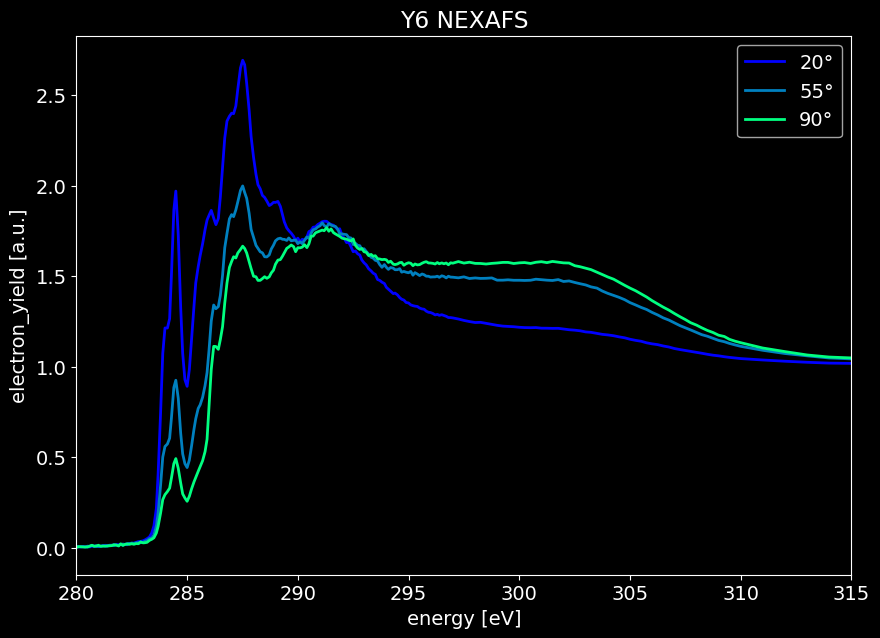

In [6]:
show_nexafs(280, 315, nexafs_exp_y6)

<div class="alert alert-block alert-info">
<b>Tip:</b> This NEXAFS has been pre- and post-edge normalized such that the pre-edge intensity is 0 and the post-edge intensity is 1. Both normalizations are necessary when viewing and analyzing orientation-dependent NEXAFS.
</div>

The variation in peak intensity with incident angle indicates that there are preferential orientations for some of the Y6 resonances. We will focus on variations in the 1s → $\pi^*$ manifold for both Y6 and PM6. These variations describe the orientation of the 1s → $\pi^*$ transition dipole moment. For a single aromatic plane, the 1s → $\pi^*$ transition dipole moment describes the direction normal to that plane.<br><br>
We will analyze the NEXAFS using the equations proposed in Stohr Ch 9. The Figures below reproduce some aspects of Stohr Figure 9.2, including labels for $\alpha$ and $\theta$.<br>
<span>Conventional polarizing NEXAFS</span><br><img src="conventional_nexafs_theta.gif" alt="Conventional NEXAFS E-field variation" color = "white" text/><br><span>Alternative/modern polarizing NEXAFS</span><br><img src="alt_nexafs_theta.gif" alt="Alternative NEXAFS E-field variation" /><br><br>
TOP: Conventional polar NEXAFS data collection scheme where the angle $\theta$ between the electric field vector and substrate normal is varied by changing the incident angle.<br>
BOTTOM: Alternative polar NEXAFS data collection scheme where the angle $\theta$ between the electric field vector and substrate normal is varied by changing polarization at a fixed incident angle using a synchrotron undulator.<br><br>
In both figures $\theta$ is the angle between the electric field vector (not always the incident angle!) and substrate normal and $\alpha$ is the angle between a NEXAFS vector resonance and substrate normal. <br><br>
Stöhr uses surface science language to describe the optical properties rather than more traditional optics formalisms:<ul><li>Stöhr <em>9.4.2 Twofold or Higher Substrate Symmetry</em> refers to <i>biaxial</i> tensor indices of refraction. <li> Stöhr <em>9.4.3 Threefold or Higher Substrate Symmetry</em> refers to <i>uniaxial</i> tensor indices of refraction.</li></ul>Stöhr only references components on the diagonal of the matrix and the extraordinary axis is always substrate normal.<br>
Our use of Stöhr here will ignore "$I^\perp$" and similar terms as they refer to contributions from the part of the electric field that is not oriented (i.e., $P<1$), which is common in bending magnet NEXAFS beamlines, which are increasingly rare. If your NEXAFS was collected on a a bending magnet beamline, these components should be taken into account. <br><br>
We will consider Stöhr's expression for uniaxial systems given in Eq. 9.16a:<br>
$I = \displaystyle\frac{1}{3}[1+\frac{1}{2}(3cos^2\theta-1)(3cos^2\alpha-1)]$

Where $I$ is the intensity of a single vector NEXAFS resonance and $\theta$ and $\alpha$ are defined in the figures and text above. Note that Stöhr 9.16a leaves out a scaling constant to the arbitrary units of absorbance / NEXAFS intensity. This equation indicates we should expect a linear relationship between absorbance and $cos^2\theta$. This linearity is a centerpiece of uniaxial NEXAFS analysis.<br><br>
The extraordinary or "para" axis of the complex index of refraction underlying the data would be parallel to the substrate normal, whereas the ordinary or "perp" axis of the complex index of refraction would be perpendicular to the substrate normal. <br>Absorbance parallel to the extraordinary axis is thus measured when $\theta=0$° and the ordinary axis is measured when $\theta=90$°. $\theta=90$° is accesible experimentally but $\theta=0$° is not (refer to the figures above); though it can be extrapolated from Eq. 9.16a.<br><br>
We can re-cast Stöhr 9.16a into more conventional anisotropic optics language by defining the $\beta$ tensor as follows

$\beta_{\pi^*} = \beta_{bare atom} + 3\begin{bmatrix} \frac{1}{3}[1-\frac{1}{2}(3cos^2\alpha-1)] & 0 & 0 \\ 0 & \frac{1}{3}[1-\frac{1}{2}(3cos^2\alpha-1)] & 0 \\ 0 & 0 & \frac{1}{3}[1+(3cos^2\alpha-1)] \end{bmatrix}\beta_{\pi^*-isotropic}$

with a coordinate order of [x, y, z] where x and y are considered parallel to ordinary and z is parallel to extraordinary. <br><br>


It is instructive to evaluate this representation at several values of $\alpha$ :<br>
$\alpha = 0$°<br>This is equivalent to a "perfect face on" molecule with $\pi^*$ parallel to substrate normal:<br><br>

$\beta_{\pi^*} = \beta_{bare atom} + 3\begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix}\beta_{\pi^*-isotropic}$<br>
$\alpha = 90$°<br>This is equivalent to a "perfect edge on" molecule with $\pi^*$ parallel to substrate plane:<br><br>
$\beta_{\pi^*} = \beta_{bare atom} + 3\begin{bmatrix} \frac{1}{2} & 0 & 0 \\ 0 & \frac{1}{2} & 0 \\ 0 & 0 & 0 \end{bmatrix}\beta_{\pi^*-isotropic}$<br>
$\alpha = 54.7$°<br>This is for a "magic angle" tilt of the $\pi^*$ vector :<br><br>
$\beta_{\pi^*} = \beta_{bare atom} + 3\begin{bmatrix} \frac{1}{3} & 0 & 0 \\ 0 & \frac{1}{3} & 0 \\ 0 & 0 & \frac{1}{3} \end{bmatrix}\beta_{\pi^*-isotropic}$
Note that the trace (sum of diagonal elements) is always preserved.

It is further important to understand how the measured intensity varies with $\theta$ at several important values of $\theta$:<br>
$I(\theta=0) = \displaystyle\frac{1}{3}[1-\frac{1}{2}(3cos^2\alpha-1)]$<br>

$I(\theta=90) = \displaystyle\frac{1}{3}[1+(3cos^2\alpha-1)]$<br>
$I(\theta=54.7) = \displaystyle\frac{1}{3}$<br>

These expressions lead to the following important fact:

$\displaystyle\frac{I(90) - I(54.7)}{I(0) - I(54.7)} = \frac{\frac{1}{3}[1+(3cos^2\alpha-1)]-\frac{1}{3}}{\frac{1}{3}[1-\frac{1}{2}(3cos^2\alpha-1)] - \frac{1}{3}} =-2$

That is to say that the difference between intensity at $\theta=90$° and $\theta=54.7$° will always be 2x the difference between intensity at $\theta=0$° and $\theta=54.7$°, regardless of the value of $\alpha$.
   

We can use the above facts to do a little analysis of the NEXAFS data we've collected here. Here is a numpy version of 9.16a:

In [7]:
def i_nexafs(α, θ):
    return 0.3333 * (
        1
        + 0.5
        * (3 * (np.cos(θ * np.pi / 180)) ** 2 - 1)
        * (3 * (np.cos(α * np.pi / 180)) ** 2 - 1)
    )

In [8]:
# define a function that will return the area under a region of the nexafs data
def int_area(e_min, e_max, nexafs):
    # make only positive:
    return (
        nexafs.sel(energy=slice(e_min, e_max)).integrate("energy").electron_yield.values
    )

A hasty line fit shown below. Note rather than fitting peaks, I'm cheating by integrating the whole asorbance at the lower-energy side of the pi* manifold. This is a common trick when evaluating and manipulating pi* resonances because there are few other contributors to absorbance in this energy range. Best practice in NEXAFS analysis is to fit a system of peaks to the data and evaluate the orientation of the peaks separately.

In [9]:
e_min = 283
e_max = 285
pi_peak_areas = int_area(e_min, e_max, nexafs_exp_y6)
θ_list = np.array([20, 55, 90])


def mse_line(my_vars, pi_peak_areas, θ_list):
    α = my_vars[0]
    const = my_vars[1]
    return ((const * i_nexafs(α, θ_list) - pi_peak_areas) ** 2).sum()


bnds = [(0, 90), (0, 10)]
res = optimize.differential_evolution(
    mse_line, bounds=bnds, args=(pi_peak_areas, θ_list), tol=1e-6
)
print(res.x)

[33.84776697  2.73420681]


The best fit is $\alpha=33.8$°. Note this is significantly tilted compared to the expectation $\alpha=0$° for a perfectly "face on" molecule.

## Y6 complex index of refraction from measured NEXAFS

Below is a wrapped kkcalc function similar to what we used in Part 1. This wrapped function accepts an xarray of nexafs labeled as above, and creates a temporary *.txt file from it. This is a workaround to kkcalc's need to have a text file on disk as the input. Future versions of kkcalc may accept array arguments directly. 

In [10]:
def run_kkcalc(nexafs_xr, x_min=270, x_max=325, chemical_formula="CH2", density=1.00):

    # save xarray as disposable text file 'scratch_nexafs.txt'
    np.savetxt(
        "scratch_nexafs.txt",
        np.c_[nexafs_xr.energy.values, nexafs_xr.electron_yield.values],
    )

    # The output of kk.kk_calculate_real is f1 and f2 terms since they are calculated using Kramers-Kronig transform

    output = kk.kk_calculate_real(
        "scratch_nexafs.txt",
        chemical_formula,
        load_options=None,
        input_data_type="Beta",
        merge_points=[x_min, x_max],
        add_background=False,
        fix_distortions=False,
        curve_tolerance=None,
        curve_recursion=100,
    )

    # Fitting to the Henke atomic scattering factors using the given stoichiometry and formula
    stoichiometry = kk.data.ParseChemicalFormula(chemical_formula)
    formula_mass = data.calculate_FormulaMass(stoichiometry)
    ASF_E, ASF_Data = kk.data.calculate_asf(stoichiometry)
    ASF_Data2 = kk.data.coeffs_to_ASF(ASF_E, np.vstack((ASF_Data, ASF_Data[-1])))
    # Conversion to delta and beta and making an xarray
    n = xr.Dataset(
        {
            "δ": (
                ["energy"],
                data.convert_data(
                    output[:, [0, 1]],
                    "ASF",
                    "refractive_index",
                    Density=density,
                    Formula_Mass=formula_mass,
                )[:, 1],
            ),
            "β": (
                ["energy"],
                data.convert_data(
                    output[:, [0, 2]],
                    "ASF",
                    "refractive_index",
                    Density=density,
                    Formula_Mass=formula_mass,
                )[:, 1],
            ),
        },
        coords={
            "energy": data.convert_data(
                output[:, [0, 1]],
                "ASF",
                "refractive_index",
                Density=density,
                Formula_Mass=formula_mass,
            )[:, 0]
        },
    )

    n.energy.attrs["unit"] = "eV"
    n.δ.attrs["unit"] = "a.u."
    n.β.attrs["unit"] = "a.u."

    os.remove("scratch_nexafs.txt")
    return n  # return an xarray

A version of the wrapped function that accepts and handles xarray with a 'cos_sq_θ' axis:

In [11]:
# wrap a function to run kkcalc on an xarray containing a cos_sq_θ dimension
def run_kkcalc_a(nexafs_xr, x_min=270, x_max=325, chemical_formula="CH2", density=1.00):
    n = []
    for cos_sq_θ in nexafs_xr.cos_sq_θ:
        n.append(
            run_kkcalc(
                nexafs_xr.sel(cos_sq_θ=cos_sq_θ, method="nearest"),
                x_min=x_min,
                x_max=x_max,
                chemical_formula=chemical_formula,
                density=density,
            )
        )
    n = xr.concat(n, dim=nexafs_xr.cos_sq_θ)
    n = n.assign_coords(θ=("cos_sq_θ", nexafs_xr.θ.values))
    return n

### Function to display complex index of refraction elements

In [12]:
# wrap a function to plot δ and β for an angle collection series
def show_n(xmin, xmax, n):
    fig = plt.figure(figsize=(h_size, v_size * 2))
    gs = gridspec.GridSpec(
        nrows=2,
        ncols=1,
        figure=fig,
        width_ratios=[1],
        height_ratios=[1, 1],
        wspace=0.05,
        hspace=0.1,
    )

    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[1, 0], sharex=ax1)

    # these are some colormaps I like that look good against black
    # this just discretizes the colors so they can be used on multiple traces
    colors = plt.cm.winter(np.linspace(0, 1, n.cos_sq_θ.size))
    colors2 = plt.cm.spring(np.linspace(0, 1, n.cos_sq_θ.size))

    for i, cos_sq_θ in enumerate(n.cos_sq_θ.values):
        theta_value = np.rad2deg(np.arccos(cos_sq_θ**0.5))
        if not np.isnan(theta_value):
            myl =  f"$\\theta$={theta_value:04.1f}°"
        else:
            myl = ""
        if i == 0:
            myl += "\"extraordinary\""
            c = "dodgerblue"
        elif i == len(n.cos_sq_θ) - 1:
            myl +="\"ordinary\""
            c = "limegreen"
        else:
            c = colors[i]
        n.δ.sel(cos_sq_θ=cos_sq_θ, method="nearest").plot(
            ax=ax1, color=c, lw=2, label=myl
        )
        n.β.sel(cos_sq_θ=cos_sq_θ, method="nearest").plot(
            ax=ax2, color=c, lw=2, label=myl
        )

    ymin1 = n.δ.sel(energy=slice(xmin, xmax)).min()
    ymax1 = n.δ.sel(energy=slice(xmin, xmax)).max()
    ax1.set_xlim(xmin, xmax)
    ax1.set_xlabel("")
    ax1.set_ylim(ymin1 - (ymax1 - ymin1) * 0.03, ymax1 + (ymax1 - ymin1) * 0.03)
    ax1.legend(loc="lower right")
    ax1.set_title("")

    ymax2 = n.β.sel(energy=slice(xmin, xmax)).max()

    ax2.legend(loc="upper right")
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(0, ymax2 + (ymax2) * 0.03)
    ax2.set_title("")
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.show()
    plt.close()

### Display "measured" Y6 complex index of refraction from measured NEXAFS

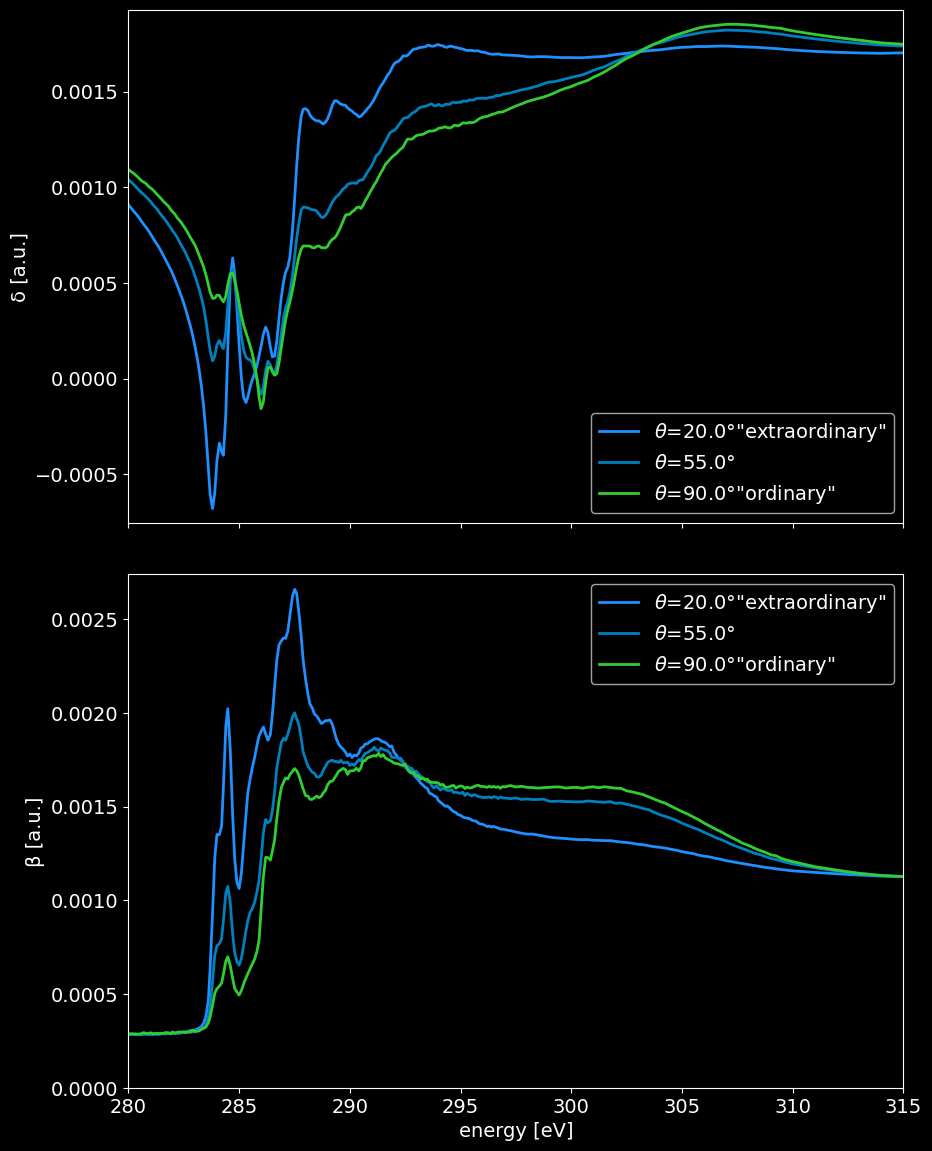

In [ ]:
show_n(280, 315, run_kkcalc_a(nexafs_exp_y6, x_min=280, x_max=315, chemical_formula=Y6_formula, density=Y6_density))

This index of refraction still isn't sufficient even to describe the unaxial function of the measured NEXAFS. That is because the extraordinary part of the complex index of refraction could only be measured by the NEXAFS measurement at a hypothetical $\theta=0$° to describe the extraordinary part correctly, and our data only goes down to $\theta=20$°. There is no experimental geometry that allows $\theta=0$°, so it must be extrapolated.

### Extrapolate Y6 NEXAFS to measured extraordinary index 


Intensity should be linear with $cos^2\theta$, so we will fit the nexafs xarray to it. The below xr.polyfit function creates a linear fit function <em>at every energy</em> in the nexafs curve.

In [14]:
nexafs_fit_y6 = nexafs_exp_y6.electron_yield.polyfit("cos_sq_θ", 1)

Now that we have a fit at every energy, we'd like to evaluate it. The current xarray implementation of xr.polyval is 'clunky,' to put it mildly.<br>
This function wraps the polyval evaluation and returns a clean nexafs dataset with appropriate metadata. This may be updated or replaced for future versions of xarray.<br>
<ul>nexafs is the original nexafs dataset<br>
nexafs_fit is returned from the polyfit as above<br>
new_cos_sq_θ is an array-like argument of cos_sq_θ values where you want the fit to be evaluated<br>
new_θ is an array-like argument of θ values to assign to those results<br></ul>

In [15]:
def evaluate_nexafs_fit(nexafs, nexafs_fit, new_cos_sq_θ, new_θ):
    nexafs_dummy = xr.Dataset(
        data_vars=dict(electron_yield=(["cos_sq_θ"], new_cos_sq_θ)),
        coords={"cos_sq_θ": new_cos_sq_θ},
        attrs=dict(description="DUMMY NEXAFS"),
    )

    # nexafs_dummy = xr.DataArray(data=new_cos_sq_θ, dims = ['cos_sq_θ'], coords = {'cos_sq_θ':new_cos_sq_θ})

    # this returns an xarray but it is unlabeled and has little of the structure, labels of the original one that was fit.
    nexafs_ep = xr.polyval(nexafs_dummy.cos_sq_θ, nexafs_fit.polyfit_coefficients)

    # I re-form it into a good dataset here by resorting to .values
    nexafs_ep = xr.Dataset(
        data_vars=dict(electron_yield=(["cos_sq_θ", "energy"], nexafs_ep.values)),
        coords={
            "cos_sq_θ": new_cos_sq_θ,
            "θ": ("cos_sq_θ", new_θ),
            "energy": nexafs_ep.energy,
        },
        attrs=dict(description=nexafs.description),
    )
    nexafs_ep.energy.attrs["unit"] = "eV"
    nexafs_ep["electron_yield"].attrs["unit"] = "a.u."
    nexafs_ep["θ"].attrs["unit"] = "°"
    return nexafs_ep

In [16]:
new_θ = np.array([0, 20, 55, 90])
new_cos_sq_θ = (np.cos(new_θ * np.pi / 180)) ** 2
nexafs_interp_y6 = evaluate_nexafs_fit(
    nexafs_exp_y6, nexafs_fit_y6, new_cos_sq_θ, new_θ
)

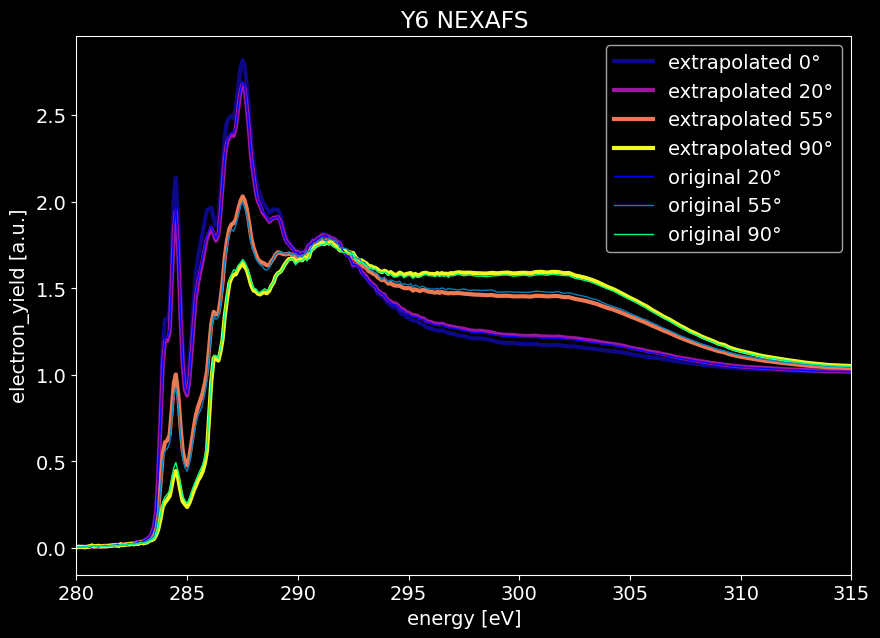

In [17]:
fig, ax1 = plt.subplots(figsize=(h_size, v_size))
# the xarray way of plotting
colors = plt.cm.plasma(np.linspace(0, 1, nexafs_interp_y6.θ.size))
colors2 = plt.cm.winter(np.linspace(0, 1, nexafs_exp_y6.θ.size))
for i, cos_sq_θ in enumerate(nexafs_interp_y6.cos_sq_θ):
    nexafs_interp_y6.electron_yield.sel(cos_sq_θ=cos_sq_θ, method="nearest").plot(
        color=colors[i], lw=3, label=f"extrapolated {nexafs_interp_y6.θ[i].values}°"
    )
for i, cos_sq_θ in enumerate(nexafs_exp_y6.cos_sq_θ):
    nexafs_exp_y6.electron_yield.sel(cos_sq_θ=cos_sq_θ, method="nearest").plot(
        color=colors2[i], lw=1, label=f"original {nexafs_exp_y6.θ[i].values}°"
    )
plt.title(nexafs_exp_y6.description)
ax1.set_xlim(280, 315)
ax1.legend()
plt.show()
plt.close()

Note that the extrapolated 90° is very close by the original 90° (this is good. it should be identical), and the extrapolated 0° has a somewhat higher pi* than the original 20°

Note that extrapolation in this manner is mathematically identical to applying a weighted difference spectrum to calculate the expectation at θ=0°. In fact it is superior because difference spectra are typically between two different θ, whereas this linear extrapolation uses all the θ information. We will exploit this sameness more later when extrapolating to the molecular frame. 

### Display Y6 complex index of refraction extrapolated to measured extraordinary index
The extrapolated NEXAFS can be the basis of a uniaxial complex index of refraction that represents material at the voxel level that is oriented the same as the material in the film. 

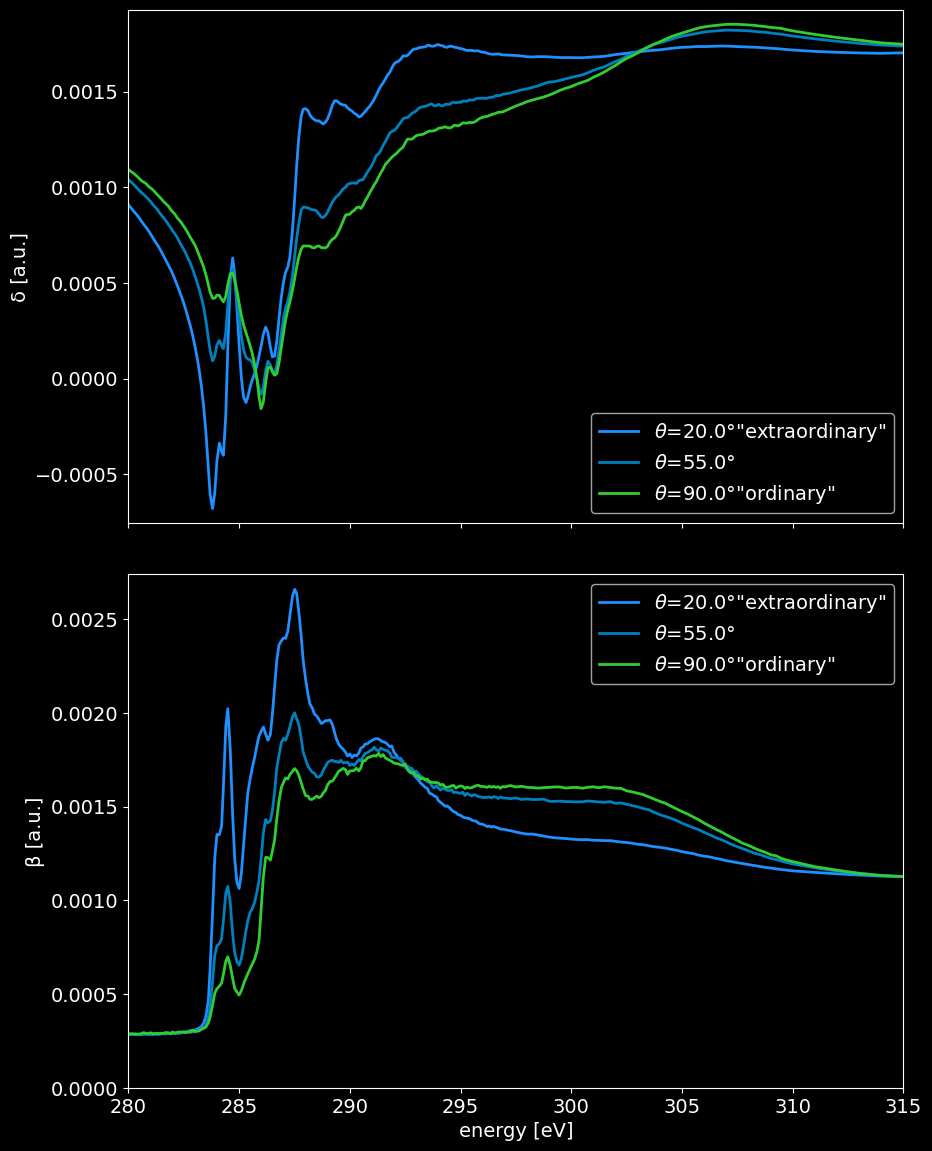

In [18]:
show_n(280, 315, run_kkcalc_a(nexafs_exp_y6, x_min=280, x_max=315, chemical_formula=Y6_formula, density=Y6_density))


## Y6 complex index of refraction from extrapolation to "molecular" frame.
But there is more we can do. The molecules at the voxel level may not be limited to the orientation extremes measured on a whole-film basis. The whole film represents an ensemble and is likely never similar to what an individual molecule or voxel is capable of unless it is sigle crystal like highly oriented pyrolytic graphite (HOPG). To develop a "molecular" complex index of refraction, we must manipulate the NEXAFS beyond what was measured. 

This manipulation requires making an assumption about how one or more resonances should behave with energy; implicit in this assumption is typically an assumption about the conformation of the molecule.

For this exercise we will assume that the molecule Y6 has a rigid and planar conjugated structure, such that the pi* resonances should follow Stohr 9.16a for $\alpha=0$°


### Develop a NEXAFS peak area fitting strategy based on comformational assumption

The function below develops a mean squared error for the area between e_min and e_max for a specific extrapolation of the nexafs curves, and a target area. The target area will be developed from our knowledge of how I should vary with $\alpha$ and $\theta$ described above.<br>
Note there is an additional contributor to mse below: if the extrapolation produces negative values for absorbance it imposes a stiff penalty because such values are unphysical.

In [19]:
def mse(cos_sq_θ, e_min, e_max, nexafs, nexafs_fit, targ):
    # compose new extrapolated nexafs based on proposed cos_sq_θ
    nexafs_new = evaluate_nexafs_fit(nexafs, nexafs_fit, [cos_sq_θ[0]], [0])
    # evaluate the difference in area between the extrapolated nexafs and the taget targ
    mse = (int_area(e_min, e_max, nexafs_new) - targ) ** 2
    minval = nexafs_new.sel(energy=slice(e_min, e_max)).electron_yield.min().values
    if minval < 0:  # impose penalty for negative absorbance values
        mse = 1e10 * mse * (-minval)
    return mse

### Determine best fit of Y6 NEXAFS to assumed conformation

For our first fit, we will attempt to make the pi* manifold absorbance zero; this would correspond to $\alpha=0, \theta=90$°

In [20]:
# these are integration bounds; we will extrapolate to "perfect" values of integrated intensity within these bounds
# which bound you choose will adjust the result slightly.
e_min = 283.7
e_max = 287
res = optimize.differential_evolution(
    mse, [(-50, 50)], args=(e_min, e_max, nexafs_exp_y6, nexafs_fit_y6, 0), tol=1e-6
)
cos_sq_θ_mol_o = float(res.x)

/tmp/ipykernel_3017409/296200672.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cos_sq_θ_mol_o = float(res.x)


For the next fit, we will attempt to make the pi* manifold maximized to correspond to $\alpha=0, \theta=0$°.<br> For a perfectly oriented $\alpha = 0$° molecule, the target would be exactly 3x the magic intensity. But our fit prefers some small amount of intensity so that absorbance doesn't go below zero. We will instead determine our target using the math above:<br><br>
$\displaystyle\frac{I(90) - I(54.7)}{I(0) - I(54.7)} = \frac{\frac{1}{3}[1+(3cos^2\alpha-1)]-\frac{1}{3}}{\frac{1}{3}[1-\frac{1}{2}(3cos^2\alpha-1)] - \frac{1}{3}} =-2$


In [21]:
magic_int_y6 = int_area(
    e_min, e_max, evaluate_nexafs_fit(nexafs_exp_y6, nexafs_fit_y6, [0.33333333], [0])
)
ord_int_y6 = int_area(
    e_min,
    e_max,
    evaluate_nexafs_fit(nexafs_exp_y6, nexafs_fit_y6, [cos_sq_θ_mol_o], [0]),
)
e_targ = magic_int_y6 + 2 * (magic_int_y6 - ord_int_y6)
# For perfectly face on, the extraordinary intensity should be exactly 3x magic intensity
res = optimize.minimize(
    mse,
    1,
    method="Nelder-Mead",
    args=(e_min, e_max, nexafs_exp_y6, nexafs_fit_y6, e_targ),
    tol=1e-6,
)
cos_sq_θ_mol_e = float(res.x)

/tmp/ipykernel_3017409/4116864685.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cos_sq_θ_mol_e = float(res.x)


In [22]:
mol_fits_y6 = [cos_sq_θ_mol_e, cos_sq_θ_mol_o]

In [23]:
nexafs_mol_y6 = evaluate_nexafs_fit(nexafs_exp_y6, nexafs_fit_y6, mol_fits_y6, [0, 90])

### Display Y6 complex index of refraction for "molecular" frame

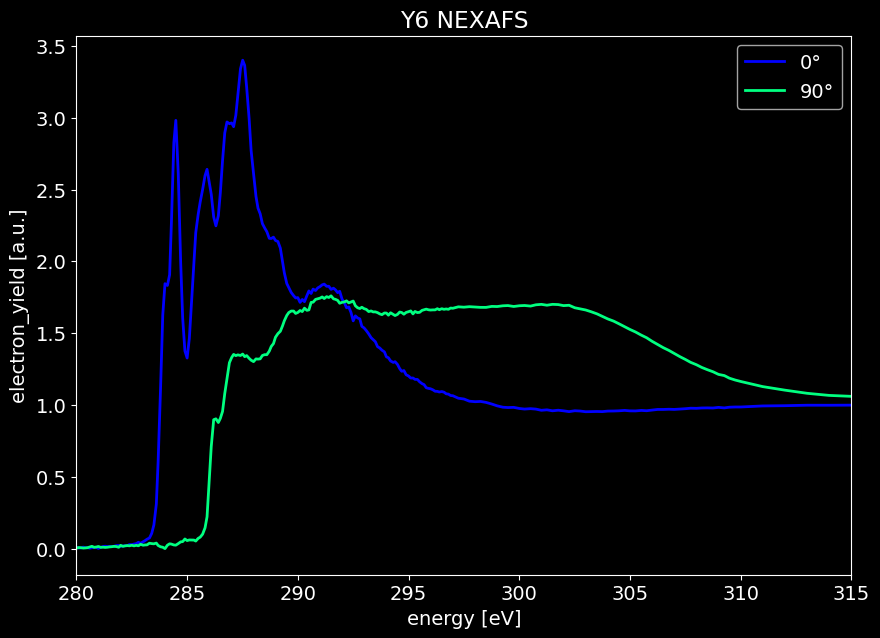

In [24]:
show_nexafs(280, 315, nexafs_mol_y6)

The NEXAFS looks fairly reasonable with this extrapolation.<br><br>Calculate complex index of refractions next:

In [25]:
n_mol_y6 = run_kkcalc_a(
    nexafs_mol_y6, x_min=280, x_max=315, chemical_formula=Y6_formula, density=Y6_density
)

/tmp/ipykernel_3017409/2257615153.py:23: RuntimeWarning: invalid value encountered in arccos
  theta_value = np.rad2deg(np.arccos(cos_sq_θ**0.5))
/tmp/ipykernel_3017409/2257615153.py:23: RuntimeWarning: invalid value encountered in scalar power
  theta_value = np.rad2deg(np.arccos(cos_sq_θ**0.5))


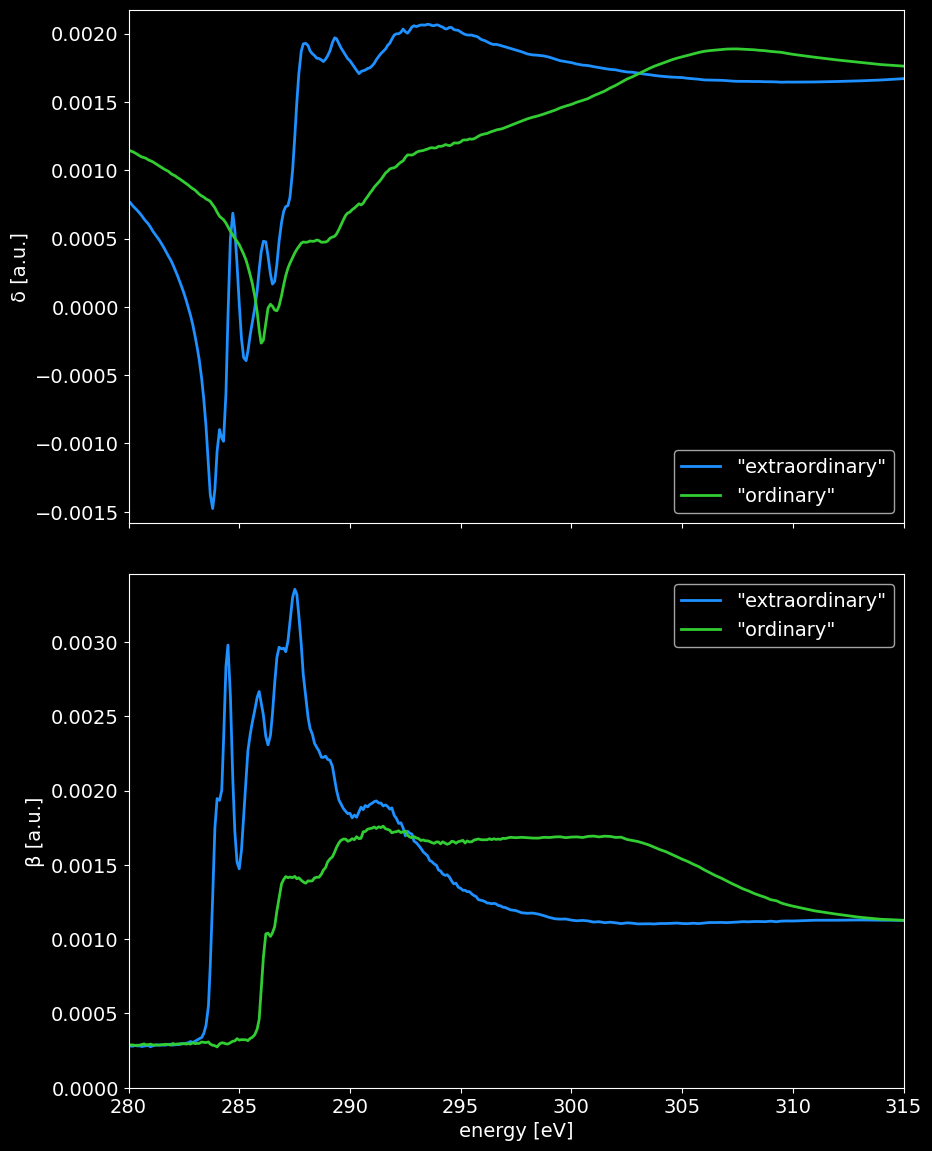

In [26]:
show_n(280, 315, n_mol_y6)

This is the complex index of refraction extrapolated to "perfect" molecular orientation.

In [27]:
# I'd also like to create a spectrum of indices of refraction at evenly spaced values of cos^2theta
# create an array with evenly spaced values of cos^2theta
# note the limits go between the extrapolated molecular params, not 0 and 1. These values map onto 0 and 1 for the new function however.
angle_spread_cos_sq_θ = np.linspace(mol_fits_y6[0], mol_fits_y6[1], 90)
angle_spread = np.degrees(np.arccos(np.linspace(1, 0, 90) ** 0.5))
# evaluate the nexafs fit function across angle_spread
nexafs_mol_y6_as = evaluate_nexafs_fit(
    nexafs_exp_y6, nexafs_fit_y6, angle_spread_cos_sq_θ, angle_spread
)
# evaluate the angle spread nexafs to index


n_mol_y6_as = run_kkcalc_a(
    nexafs_mol_y6_as,
    x_min=280,
    x_max=315,
    chemical_formula=Y6_formula, 
    density=Y6_density,
)

In [28]:
# replace unphysical extrapolated cos^2theta values with ones that are correct for the new frame
cos_sq_θ_new = xr.DataArray(np.linspace(1, 0, 90), dims="cos_sq_θ")
n_mol_y6_as.update(dict(cos_sq_θ=cos_sq_θ_new))

<xarray.Dataset> Size: 1MB
Dimensions:   (cos_sq_θ: 90, energy: 738)
Coordinates:
  * energy    (energy) float64 6kB 10.0 10.16 10.33 10.49 ... 1e+05 1e+05 5e+05
  * cos_sq_θ  (cos_sq_θ) float64 720B 1.0 0.9888 0.9775 ... 0.02247 0.01124 0.0
    θ         (cos_sq_θ) float64 720B 0.0 6.085 8.621 10.58 ... 81.38 83.92 90.0
Data variables:
    δ         (cos_sq_θ, energy) float64 531kB -0.1809 -0.1997 ... 9.634e-10
    β         (cos_sq_θ, energy) float64 531kB 0.294 0.299 ... 9.207e-16

### Save "molecular" Y6 complex index of refraction in NRSS-compatible form

In [29]:
# save data to a txt file in a format that could be imported into CyRSoXS
# note that 0° is extraordinary and 90° is ordinary as those are the θ values where the measurement only perceives one or the other.
# the order of the columns is thus the order described below
# note for this, we only need the para and perp components

np.savetxt(
    "y6_molecular.txt",
    np.c_[
        n_mol_y6.energy,
        n_mol_y6.δ.sel(
            cos_sq_θ=cos_sq_θ_mol_e, method="nearest"
        ).values,  # extraordinary, para
        n_mol_y6.β.sel(
            cos_sq_θ=cos_sq_θ_mol_e, method="nearest"
        ).values,  # extraordinary, para
        n_mol_y6.δ.sel(
            cos_sq_θ=cos_sq_θ_mol_o, method="nearest"
        ).values,  # ordinary, perp
        n_mol_y6.β.sel(cos_sq_θ=cos_sq_θ_mol_o, method="nearest").values,
    ],
    header="Energy\tDeltaPara\tBetaPara\tDeltaPerp\tBetaPerp",
    delimiter="\t",
    comments="",
)  # ordinary, perp) #ordinary, perp

## Y6 Contrast: (oriented Y6):vacuum contrast

Because the Y6 complex index of refraction is anisotropic, there is not a single vacuum contrast but rather a series of contrasts depending on the mixing of the ordinary and extraordinary complex index of refraction elements. Otherwise the calculation is identical to the calculation discussed in Part 1.

### A function for calculating binary contrasts between two complex indices of refraction

In [30]:
# this wrapper function is the same as described in Part 1
# this will accept and return xarrays
def binary_contrast(n1, n2=None):
    if n2 is None:
        # second component is vacuum
        n2 = xr.zeros_like(n1)
    else:
        # second is interpolated to match the energy array of the first component.
        n2 = n2.interp(energy=n1.energy)
    return n1.energy**4 * ((n1.δ - n2.δ) ** 2 + (n1.β - n2.β) ** 2)

In [31]:
contrast_n_mol_y6_vac = binary_contrast(n_mol_y6_as)

### Display (isotropic Y6):vacuum contrast 

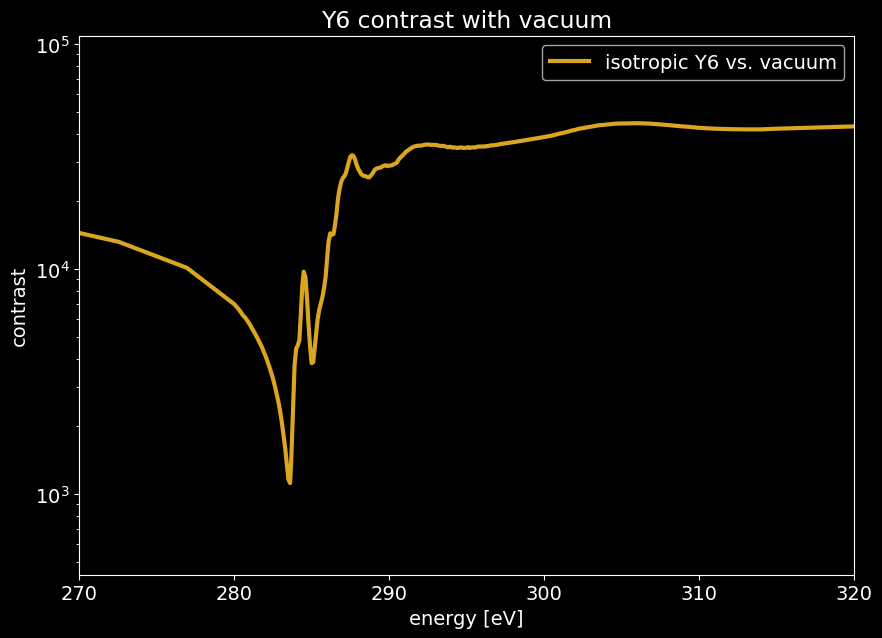

In [32]:
# plot the contrasts
xmin = 270
xmax = 320
fig, ax1 = plt.subplots(figsize=(h_size, v_size))
# xarray way of adding to a plot
contrast_n_mol_y6_vac.sel(cos_sq_θ=0.3333333, method="nearest").plot(
    ax=ax1, color="goldenrod", lw=3, label="isotropic Y6 vs. vacuum"
)
ax1.set_xlim(xmin, xmax)
ymin = contrast_n_mol_y6_vac.sel(energy=slice(xmin, xmax)).min()
ymax = contrast_n_mol_y6_vac.sel(energy=slice(xmin, xmax)).max()
ax1.set_ylim(ymin * 0.75, ymax * 1.2)
ax1.set_yscale("log")
ax1.set_ylabel("contrast")
ax1.legend()
plt.title("Y6 contrast with vacuum")
plt.show()
plt.close()

### Display (oriented Y6):vacuum contrast

Because the complex index of refraction for Y6 varies depending on the dot product of the incident electric field vector with the oriented Y6, the vacuum contrast can range from vacuum:Y6-ordinary to vacuum:y6:extraordinary. 

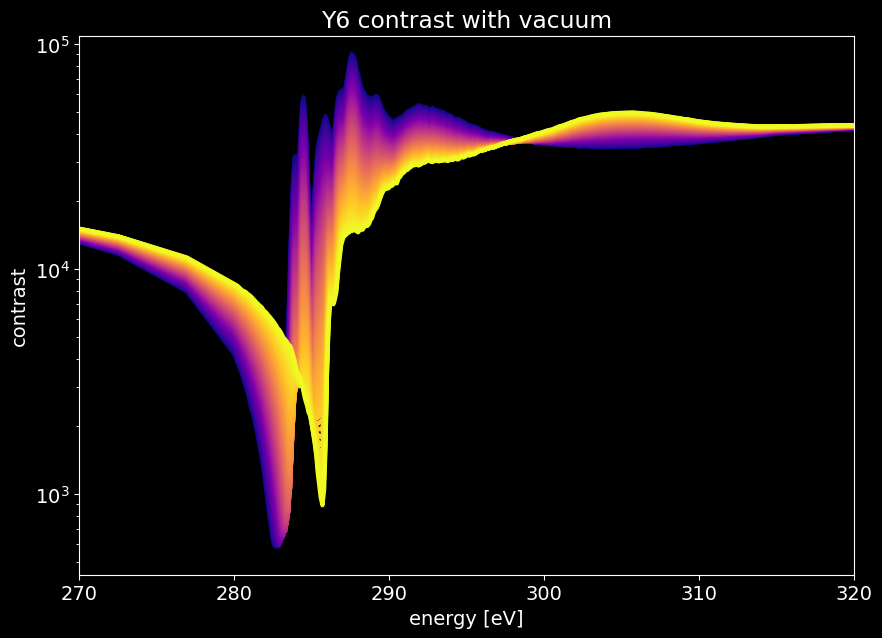

In [33]:
# plot the contrasts
xmin = 270
xmax = 320
fig, ax1 = plt.subplots(figsize=(h_size, v_size))
# xarray way of adding to a plot
colors = plt.cm.plasma(np.linspace(0, 1, contrast_n_mol_y6_vac.θ.size))
for i, cos_sq_θ in enumerate(contrast_n_mol_y6_vac.cos_sq_θ):
    contrast_n_mol_y6_vac.sel(cos_sq_θ=cos_sq_θ, method="nearest").plot(
        ax=ax1, color=colors[i], lw=3
    )
ax1.set_xlim(xmin, xmax)
ymin = contrast_n_mol_y6_vac.sel(energy=slice(xmin, xmax)).min()
ymax = contrast_n_mol_y6_vac.sel(energy=slice(xmin, xmax)).max()
ax1.set_ylim(ymin * 0.75, ymax * 1.2)
ax1.set_yscale("log")
ax1.set_ylabel("contrast")
plt.title("Y6 contrast with vacuum")
plt.show()
plt.close()

This envelope properly describes the possibilities for vacuum contrast with Y6.
## PM6 NEXAFS and its anisotropic complex index of refraction
Repeat the process for PM6:
### PM6 NEXAFS

In [34]:
pey = np.loadtxt("pm6_nexafs.txt").T

# wrap in an xarray
# we have a different array of angles here than for Y6

θ_val = np.array([33, 44, 55, 70])

nexafs_pm6 = xr.Dataset(
    data_vars=dict(electron_yield=(["cos_sq_θ", "energy"], pey[1:5])),
    coords={
        "cos_sq_θ": np.cos(θ_val * np.pi / 180) ** 2,
        "θ": ("cos_sq_θ", θ_val),
        "energy": pey[0],
    },
    attrs=dict(description="PM6 NEXAFS"),
)
nexafs_pm6.energy.attrs["unit"] = "eV"
nexafs_pm6["electron_yield"].attrs["unit"] = "a.u."
nexafs_pm6["θ"].attrs["unit"] = "°"

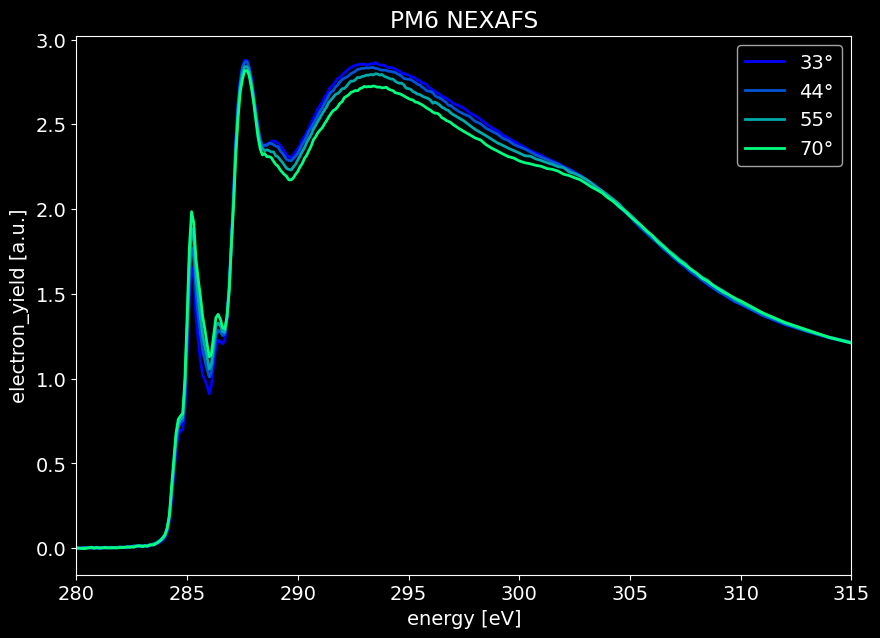

In [35]:
show_nexafs(280, 315, nexafs_pm6)

### Extrapolate PM6 to its measured extraordinary index
It is only subtly oriented. We can fit as before:

In [36]:
e_min = 283
e_max = 285
pi_peak_areas_pm6 = int_area(e_min, e_max, nexafs_pm6)
θ_list = np.array([33, 44, 55, 70])

bnds = [(0, 90), (0, 10)]
res = optimize.differential_evolution(
    mse_line, bounds=bnds, args=(pi_peak_areas_pm6, θ_list), tol=1e-6
)
print(res.x)

[58.16534043  1.79162161]


We find that there is a subtle "edge on" orientation with $\alpha=58.1$°<br>
We can run the same linear fit at each energy:

In [37]:
nexafs_fit_pm6 = nexafs_pm6.electron_yield.polyfit("cos_sq_θ", 1)

We now must choose extrapolation targets. The consideration is different this time because this PM6 is preferentially edge on. It is not correct to "flip" a measured NEXAFS from edge to face because it is not possible to separate the 2 contributors to the ordinary axis. So we will extrapolate this NEXAFS to "perfect" edge on behavior. Thus for the extraordinary axis, we would expect zero pi* intensity:  

In [38]:
# these are integration bounds; we will extrapolate to "perfect" values of integrated intensity within these bounds
# which bound you choose will adjust the result slightly.
e_min = 284
e_max = 286
res = optimize.differential_evolution(
    mse, [(-50, 50)], args=(e_min, e_max, nexafs_pm6, nexafs_fit_pm6, 0), tol=1e-6
)
cos_sq_θ_mol_e = float(res.x)

/tmp/ipykernel_3017409/2231388600.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cos_sq_θ_mol_e = float(res.x)


The ordinary axis intensity is once again guided by our distance relationship between magic and the extremes. In this case the difference is halved rather than doubled because we started with extraordinary rather than ordinary.

In [ ]:
# For perfectly face on, the extraordinary intensity should be exactly 3x magic intensity
magic_int_pm6 = int_area(
    e_min, e_max, evaluate_nexafs_fit(nexafs_pm6, nexafs_fit_pm6, [0.333333333], [0])
)
extra_int_pm6 = int_area(
    e_min, e_max, evaluate_nexafs_fit(nexafs_pm6, nexafs_fit_pm6, [cos_sq_θ_mol_e], [0])
)

e_targ = magic_int_pm6 + 0.5 * (magic_int_pm6 - extra_int_pm6)
res = optimize.minimize(
    mse,
    1,
    method="Nelder-Mead",
    args=(e_min, e_max, nexafs_pm6, nexafs_fit_pm6, e_targ),
    tol=1e-6,
)
cos_sq_θ_mol_o = float(res.x)

/tmp/ipykernel_3017409/1520926771.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cos_sq_θ_mol_o = float(res.x)


In [40]:
cos_sq_θ_mol_e

2.4961180468148325

In [41]:
mol_fits_pm6 = [cos_sq_θ_mol_e, 0.333333333, cos_sq_θ_mol_o]

In [42]:
nexafs_mol_pm6 = evaluate_nexafs_fit(
    nexafs_pm6, nexafs_fit_pm6, mol_fits_pm6, [0, 55, 90]
)

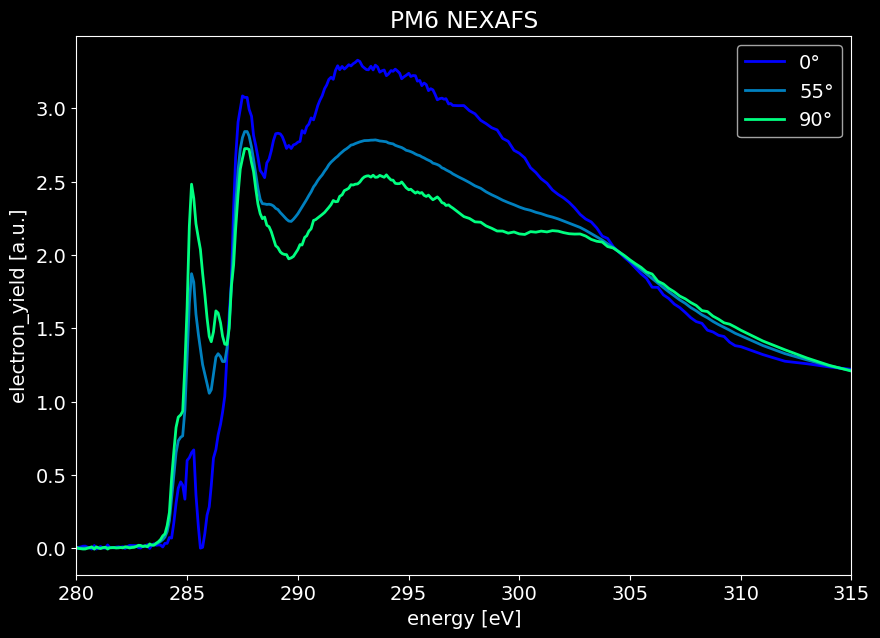

In [43]:
show_nexafs(280, 315, nexafs_mol_pm6)

In [44]:
n_mol_pm6_as = run_kkcalc_a(nexafs_mol_pm6, x_min = 280, x_max = 315, chemical_formula = PM6_formula, density = PM6_density)

/tmp/ipykernel_3017409/2257615153.py:23: RuntimeWarning: invalid value encountered in arccos
  theta_value = np.rad2deg(np.arccos(cos_sq_θ**0.5))
/tmp/ipykernel_3017409/2257615153.py:23: RuntimeWarning: invalid value encountered in scalar power
  theta_value = np.rad2deg(np.arccos(cos_sq_θ**0.5))


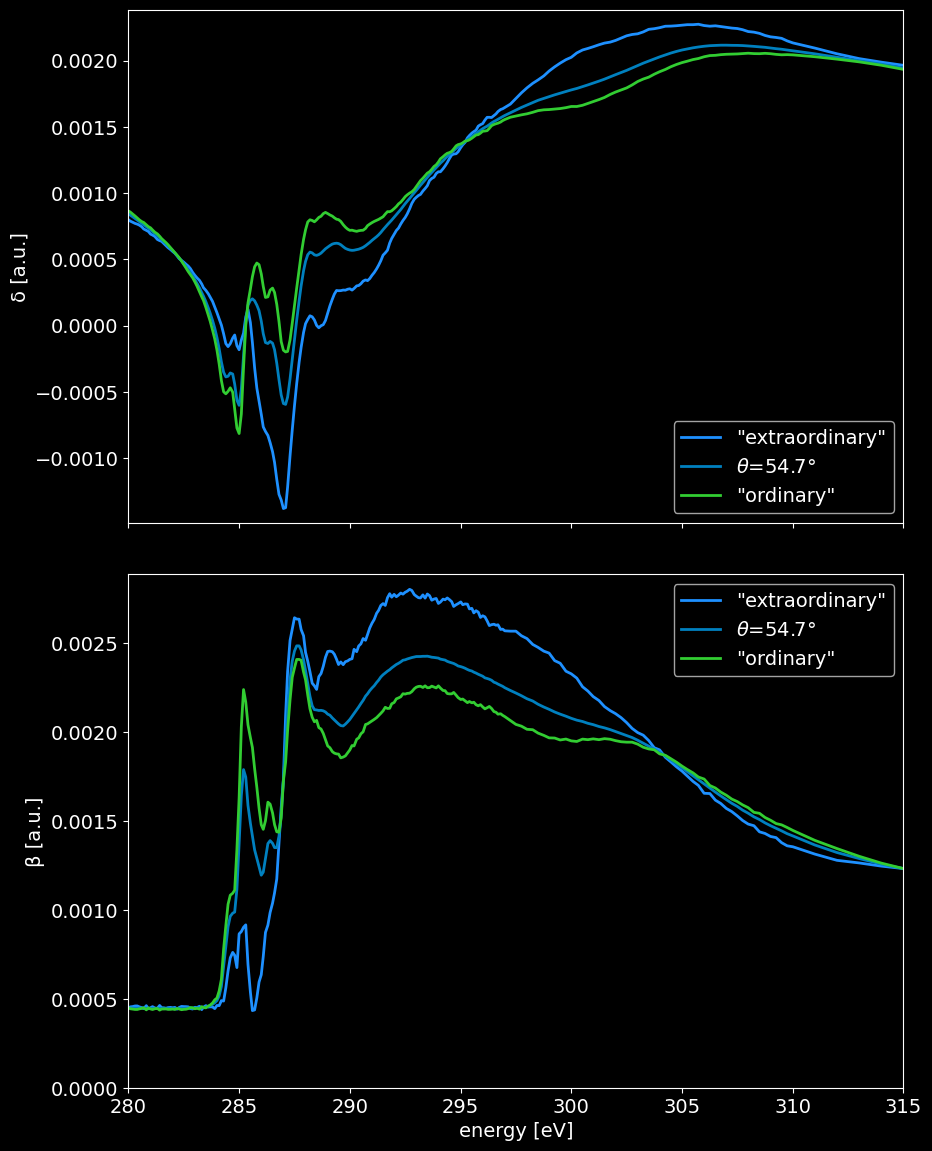

In [45]:
show_n(280, 315, n_mol_pm6_as)

## PM6 NEXAFS and complex index of refraction recast as "face on"

Ddescribing the orientation of PM6 in NRSS models is more straightforward if the extraordinary direction is parallel to the conjugated plane normal, so we "recast" the NEXAFS to describe a "face on" PM6. Tpo do this this leans sharply into the assumption that the NEXAFS can be treated as uniaxial, because we are assuming that the measured extraordinary direction for "edge-on" PM6  describes both the long and short directions of the conjguated plane of the molecule correctly.

### Recasting PM6 NEXAFS
We develop a new series of NEXAFS based on recombining the ordinary and extraordinary elements, then construct a NEXAFS xarray from it.

In [46]:
nexafs_inv_0 = (
    nexafs_mol_pm6.sel(cos_sq_θ=cos_sq_θ_mol_o, method="nearest").electron_yield.values
    - 0.5
    * nexafs_mol_pm6.sel(
        cos_sq_θ=cos_sq_θ_mol_e, method="nearest"
    ).electron_yield.values
) * 2

# magic is same
nexafs_inv_55 = nexafs_mol_pm6.sel(
    cos_sq_θ=0.3333333, method="nearest"
).electron_yield.values

nexafs_inv_90 = nexafs_mol_pm6.sel(
    cos_sq_θ=cos_sq_θ_mol_e, method="nearest"
).electron_yield.values

In [47]:
θ_val = np.array([0, 55, 90])

nexafs_pm6_inv = xr.Dataset(
    data_vars=dict(
        electron_yield=(
            ["cos_sq_θ", "energy"],
            np.array([nexafs_inv_0, nexafs_inv_55, nexafs_inv_90]),
        )
    ),
    coords={
        "cos_sq_θ": np.cos(θ_val * np.pi / 180) ** 2,
        "θ": ("cos_sq_θ", θ_val),
        "energy": nexafs_mol_pm6.energy.values,
    },
    attrs=dict(description="PM6 NEXAFS"),
)
nexafs_pm6_inv.energy.attrs["unit"] = "eV"
nexafs_pm6_inv["electron_yield"].attrs["unit"] = "a.u."
nexafs_pm6_inv["θ"].attrs["unit"] = "°"

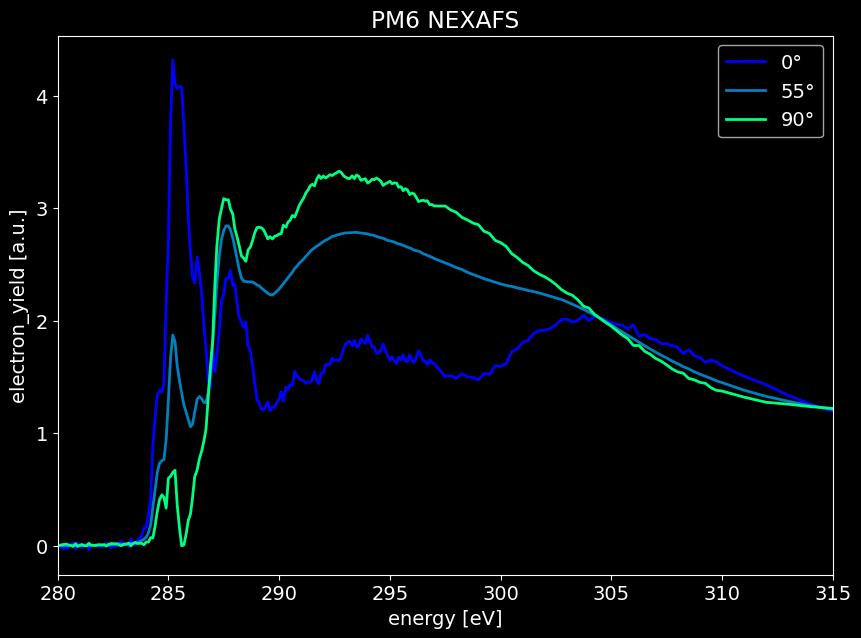

In [48]:
show_nexafs(280, 315, nexafs_pm6_inv)

In [49]:
n_mol_pm6 = run_kkcalc_a(
    nexafs_pm6_inv,
    x_min=280,
    x_max=315,
    chemical_formula=PM6_formula,
    density=PM6_density,
)

### Display PM6 complex index of refraction for recast "face on" PM6

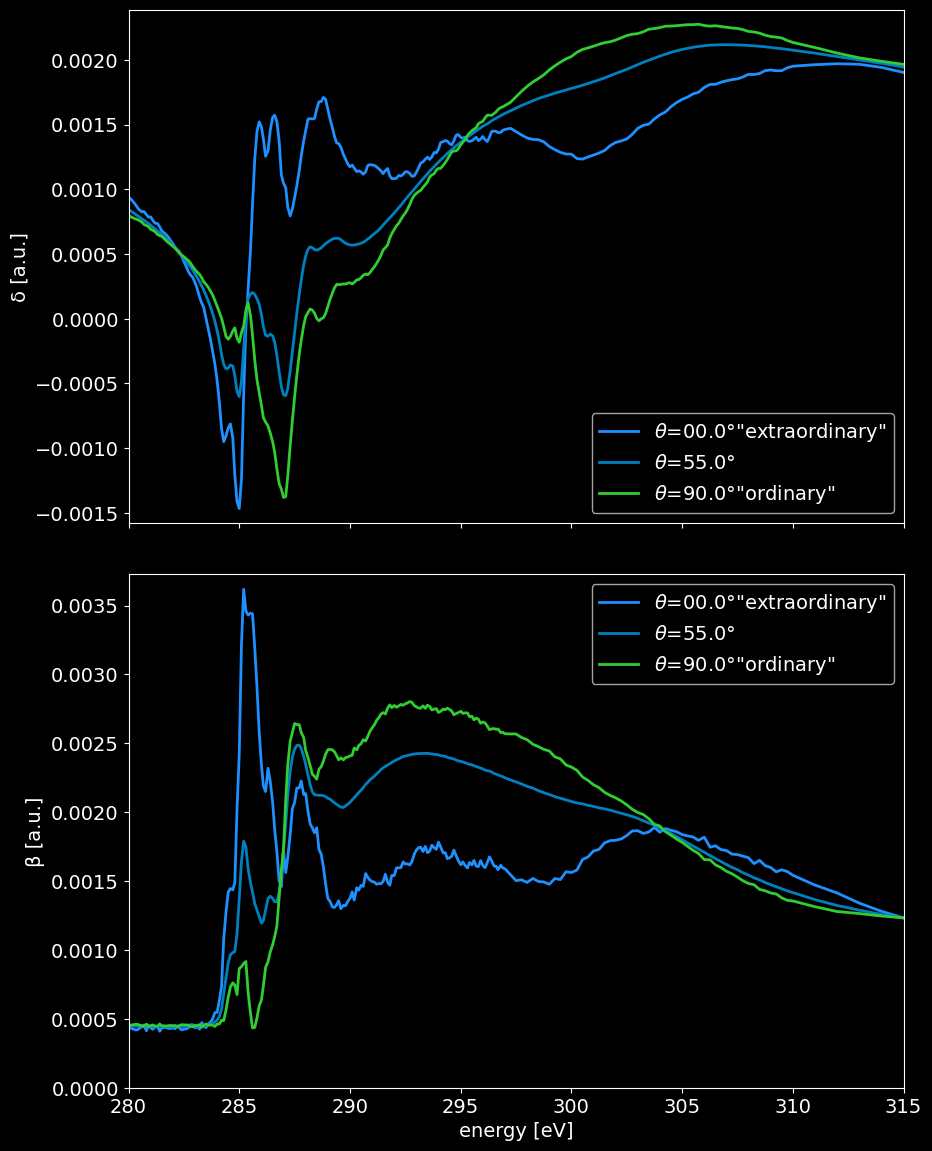

In [50]:
show_n(280, 315, n_mol_pm6)

### Save "molecular" PM6 complex index of refraction in NRSS-compatible form

In [51]:
np.savetxt(
    "pm6_molecular.txt",
    np.c_[
        n_mol_pm6.energy,
        n_mol_pm6.δ.sel(cos_sq_θ=1, method="nearest").values,  # extraordinary, para
        n_mol_pm6.β.sel(cos_sq_θ=1, method="nearest").values,  # extraordinary, para
        n_mol_pm6.δ.sel(cos_sq_θ=0, method="nearest").values,  # ordinary, perp
        n_mol_pm6.β.sel(cos_sq_θ=0, method="nearest").values,
    ],
    header="Energy\tDeltaPara\tBetaPara\tDeltaPerp\tBetaPerp",
    delimiter="\t",
    comments="",
)  # ordinary, perp

### Display (oriented PM6):vacuum contrast

Just as before, run extrapolation finely divided within fit extremes. 

In [52]:
# run another quick fit; this is just with the three points
nexafs_pm6_inv_fit = nexafs_pm6_inv.electron_yield.polyfit("cos_sq_θ", 1)
angle_spread_cos_sq_θ = np.linspace(1, 0, 90)
angle_spread = np.degrees(np.arccos(angle_spread_cos_sq_θ**0.5))
# evaluate the nexafs fit function across angle_spread
nexafs_mol_pm6_as = evaluate_nexafs_fit(
    nexafs_pm6_inv, nexafs_pm6_inv_fit, angle_spread_cos_sq_θ, angle_spread
)
# evaluate the angle spread nexafs to index
n_mol_pm6_as = run_kkcalc_a(
    nexafs_mol_pm6_as,
    x_min=280,
    x_max=315,
    chemical_formula=PM6_formula, 
    density=PM6_density,
)

In [53]:
contrast_n_mol_pm6_vac = binary_contrast(n_mol_pm6_as)

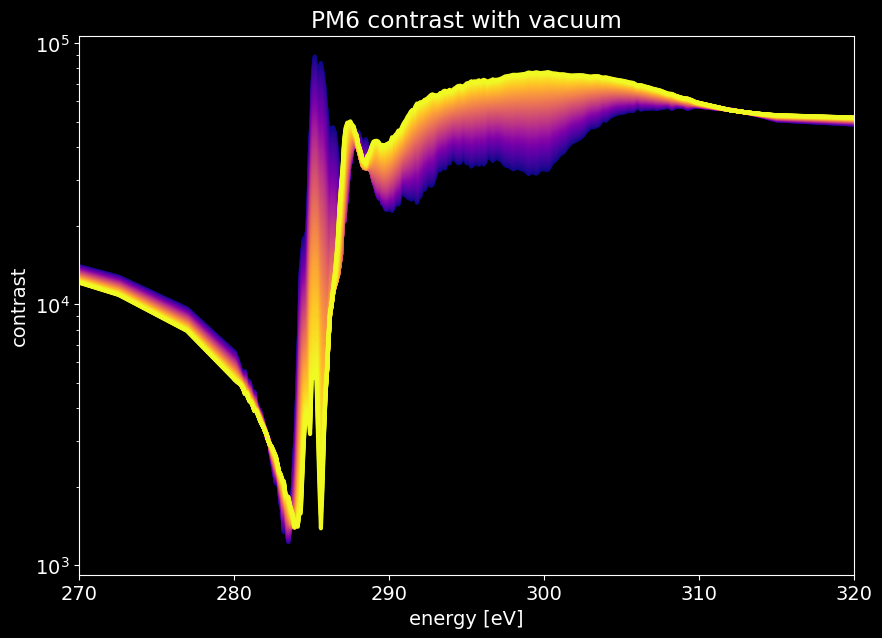

In [54]:
# plot the contrasts
xmin = 270
xmax = 320
fig, ax1 = plt.subplots(figsize=(h_size, v_size))
# xarray way of adding to a plot
colors = plt.cm.plasma(np.linspace(0, 1, contrast_n_mol_y6_vac.θ.size))
for i, cos_sq_θ in enumerate(contrast_n_mol_pm6_vac.cos_sq_θ):
    contrast_n_mol_pm6_vac.sel(cos_sq_θ=cos_sq_θ, method="nearest").plot(
        ax=ax1, color=colors[i], lw=3
    )
ax1.set_xlim(xmin, xmax)
ymin = contrast_n_mol_pm6_vac.sel(energy=slice(xmin, xmax)).min()
ymax = contrast_n_mol_pm6_vac.sel(energy=slice(xmin, xmax)).max()
ax1.set_ylim(ymin * 0.75, ymax * 1.2)
ax1.set_yscale("log")
ax1.set_ylabel("contrast")
plt.title("PM6 contrast with vacuum")
plt.show()
plt.close()

## Explore contrasts between Y6 and PM6

In [55]:
n_mol_y6_as_combi = n_mol_y6_as.rename_dims(dict(cos_sq_θ="cos_sq_θ_y6")).drop("θ")
n_mol_y6_as_combi = n_mol_y6_as_combi.rename_vars(dict(cos_sq_θ="cos_sq_θ_y6"))

n_mol_pm6_as_combi = n_mol_pm6_as.rename_dims(dict(cos_sq_θ="cos_sq_θ_pm6")).drop("θ")
n_mol_pm6_as_combi = n_mol_pm6_as_combi.rename_vars(dict(cos_sq_θ="cos_sq_θ_pm6"))

/tmp/ipykernel_3017409/3269874752.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  n_mol_y6_as_combi = n_mol_y6_as.rename_dims(dict(cos_sq_θ="cos_sq_θ_y6")).drop("θ")
/tmp/ipykernel_3017409/3269874752.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  n_mol_pm6_as_combi = n_mol_pm6_as.rename_dims(dict(cos_sq_θ="cos_sq_θ_pm6")).drop("θ")


In [56]:
n_mol_c = []
for cos_sq_θ in n_mol_y6_as_combi.cos_sq_θ_y6:
    n_mol_c.append(
        binary_contrast(
            n_mol_y6_as_combi.sel(cos_sq_θ_y6=cos_sq_θ, method="nearest"),
            n_mol_pm6_as_combi,
        )
    )
n_mol_c = xr.concat(n_mol_c, "cos_sq_θ_y6")

In [57]:
n_mol_c.interp(cos_sq_θ_y6=0.3333333).interp(cos_sq_θ_pm6=0.3333333).sel(
    energy=slice(283, 286)
).idxmax()

<xarray.DataArray 'energy' ()> Size: 8B
array(285.1)
Coordinates:
    cos_sq_θ_y6   float64 8B 0.3333
    cos_sq_θ_pm6  float64 8B 0.3333

### Display (isotropic Y6):(isotropic PM6) contrast
Contrast between isotropic Y6 and isotropic PM6

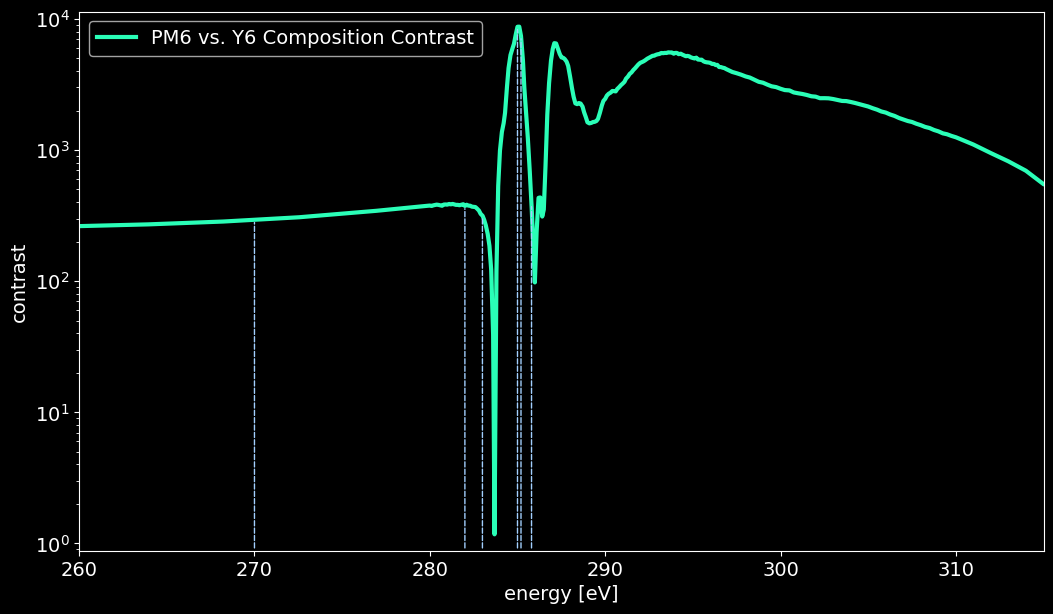

In [58]:
# plot the contrasts
xmin = 260
xmax = 315
fig, ax1 = plt.subplots(figsize=(1920 * v_size / 1080, v_size))
# xarray way of adding to a plot
n_mol_c.interp(cos_sq_θ_y6=0.3333333).interp(cos_sq_θ_pm6=0.3333333).plot(
    ax=ax1, color="xkcd:greenish cyan", lw=3, label="PM6 vs. Y6 Composition Contrast"
)
ax1.set_xlim(xmin, xmax)
ymin = (
    n_mol_c.interp(cos_sq_θ_y6=0.3333333)
    .interp(cos_sq_θ_pm6=0.3333333)
    .sel(energy=slice(xmin, xmax))
    .min()
    * 0.75
)
ymax = (
    n_mol_c.interp(cos_sq_θ_y6=0.3333333)
    .interp(cos_sq_θ_pm6=0.3333333)
    .sel(energy=slice(xmin, xmax))
    .max()
    * 1.3
)

for e in [270, 282, 283, 285, 285.2, 285.8]:
    gtop = (
        n_mol_c.interp(cos_sq_θ_y6=0.3333333)
        .interp(cos_sq_θ_pm6=0.3333333)
        .interp(energy=e)
    )
    xy = [e, gtop]
    ax1.annotate(
        "",
        xy=xy,
        xytext=(xy[0], ymin),
        xycoords="data",
        arrowprops=dict(
            arrowstyle="-",
            linestyle="--",
            linewidth=1,
            zorder=0,
            color="xkcd:baby blue",
        ),
    )

ax1.set_ylim(ymin, ymax)
ax1.set_yscale("log")
ax1.set_ylabel("contrast")
ax1.legend()
plt.title("")
plt.show()
plt.close()

### Display (isotropic Y6):vacuum, (isotropic PM6):vacuum contrasts

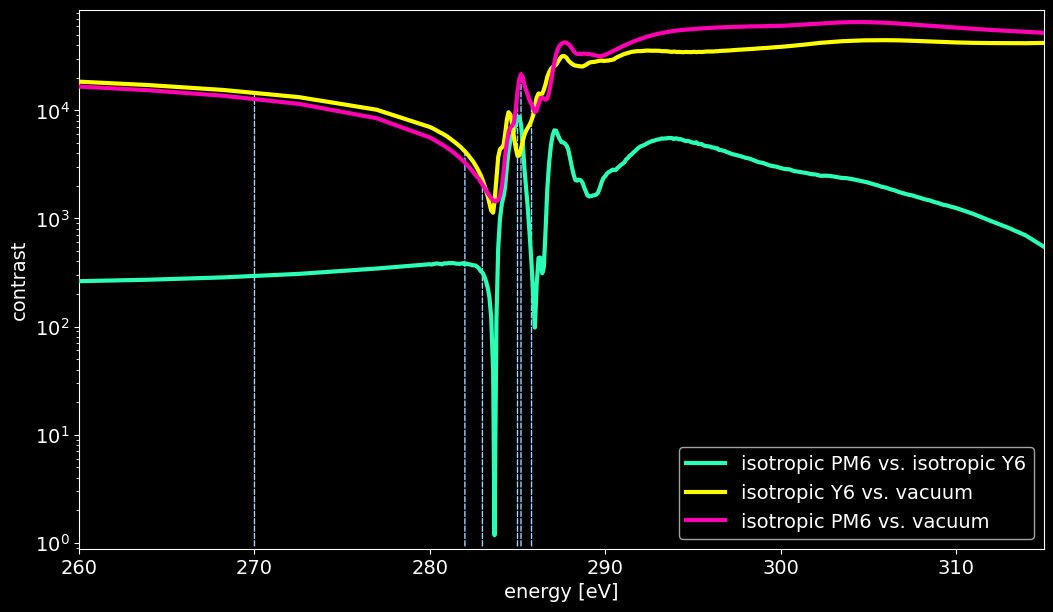

In [59]:
# plot the contrasts
xmin = 260
xmax = 315
fig, ax1 = plt.subplots(figsize=(1920 * v_size / 1080, v_size))
# xarray way of adding to a plot
n_mol_c.interp(cos_sq_θ_y6=0.3333333).interp(cos_sq_θ_pm6=0.3333333).plot(
    ax=ax1,
    color="xkcd:greenish cyan",
    lw=3,
    label="isotropic PM6 vs. isotropic Y6",
    zorder=1000,
)
contrast_n_mol_y6_vac.interp(cos_sq_θ=0.3333333).plot(
    ax=ax1,
    color="xkcd:bright yellow",
    lw=3,
    label="isotropic Y6 vs. vacuum",
    zorder=1000,
)
contrast_n_mol_pm6_vac.interp(cos_sq_θ=0.3333333).plot(
    ax=ax1,
    color="xkcd:bright pink",
    lw=3,
    label="isotropic PM6 vs. vacuum",
    zorder=1000,
)
ax1.set_xlim(xmin, xmax)
ymin = (
    n_mol_c.interp(cos_sq_θ_y6=0.3333333)
    .interp(cos_sq_θ_pm6=0.3333333)
    .sel(energy=slice(xmin, xmax))
    .min()
    * 0.75
)
ymax = (
    contrast_n_mol_pm6_vac.interp(cos_sq_θ=0.3333333)
    .sel(energy=slice(xmin, xmax))
    .max()
    * 1.3
)


for e in [270, 282, 283, 285, 285.2, 285.8]:
    gtop = np.maximum(
        n_mol_c.interp(cos_sq_θ_y6=0.3333333)
        .interp(cos_sq_θ_pm6=0.3333333)
        .interp(energy=e),
        contrast_n_mol_pm6_vac.interp(cos_sq_θ=0.3333333).interp(energy=e),
    )
    gtop = np.maximum(
        gtop, contrast_n_mol_y6_vac.interp(cos_sq_θ=0.3333333).interp(energy=e)
    )
    xy = [e, gtop]
    ax1.annotate(
        "",
        xy=xy,
        xytext=(xy[0], ymin),
        xycoords="data",
        arrowprops=dict(
            arrowstyle="-",
            linestyle="--",
            linewidth=1,
            zorder=0,
            color="xkcd:baby blue",
        ),
    )

ax1.set_ylim(ymin, ymax)
ax1.set_yscale("log")
ax1.set_ylabel("contrast")
ax1.legend(loc=4)
plt.title("")
plt.show()
plt.close()

### Display (oriented Y6):(isotropic PM6) contrast

In [60]:
a = [] * 10

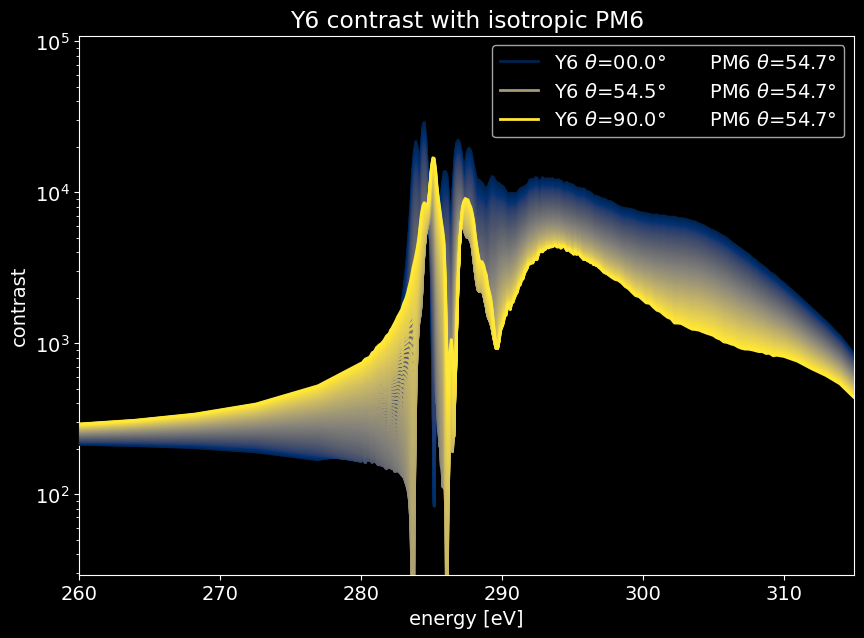

In [61]:
import matplotlib.pyplot as plt
import matplotlib.lines
from matplotlib import colormaps

fig, ax1 = plt.subplots(figsize=(h_size, v_size))
a = []
label_thetas = np.array([0, 54.7, 90])
for i, cos_sq_θ_y6 in enumerate(n_mol_c.cos_sq_θ_y6.values):
    fracval = i / (n_mol_c.cos_sq_θ_y6.values.shape[0] - 1)

    y6_theta = np.rad2deg(np.arccos(cos_sq_θ_y6**0.5))
    pm6_theta = np.rad2deg(np.arccos(0.33333**0.5))

    do_label = np.abs(y6_theta - label_thetas) < 0.2

    if any(do_label):
        trace_label = f"Y6 $\\theta$={y6_theta:04.1f}°"
        trace_label += f"\tPM6 $\\theta$={pm6_theta:04.1f}°"
    else:
        trace_label = ""

    line = (
        n_mol_c.interp(cos_sq_θ_y6=cos_sq_θ_y6)
        .interp(cos_sq_θ_pm6=0.3333333)
        .plot(
            ax=ax1,
            color=colormaps["cividis"](fracval),
            lw=2,
            label=trace_label,
            zorder=1000,
        )
    )
    a.append(line)
ax1.set_xlim(xmin, xmax)
ymin = contrast_n_mol_y6_vac.sel(energy=slice(xmin, xmax)).min()
ymax = contrast_n_mol_y6_vac.sel(energy=slice(xmin, xmax)).max()
ax1.set_ylim(ymin * 0.05, ymax * 1.2)
ax1.set_yscale("log")
ax1.set_ylabel("contrast")
plt.title("Y6 contrast with isotropic PM6")

plt.legend()
plt.show()
plt.close()

### Display (oriented Y6):(oriented PM6) contrast

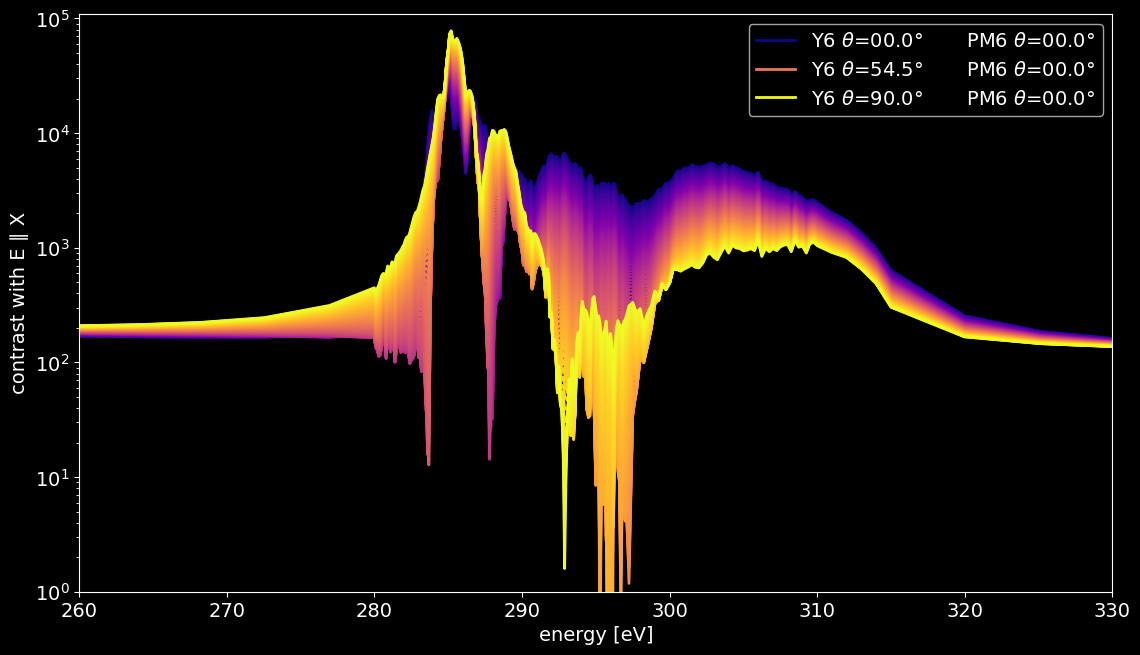

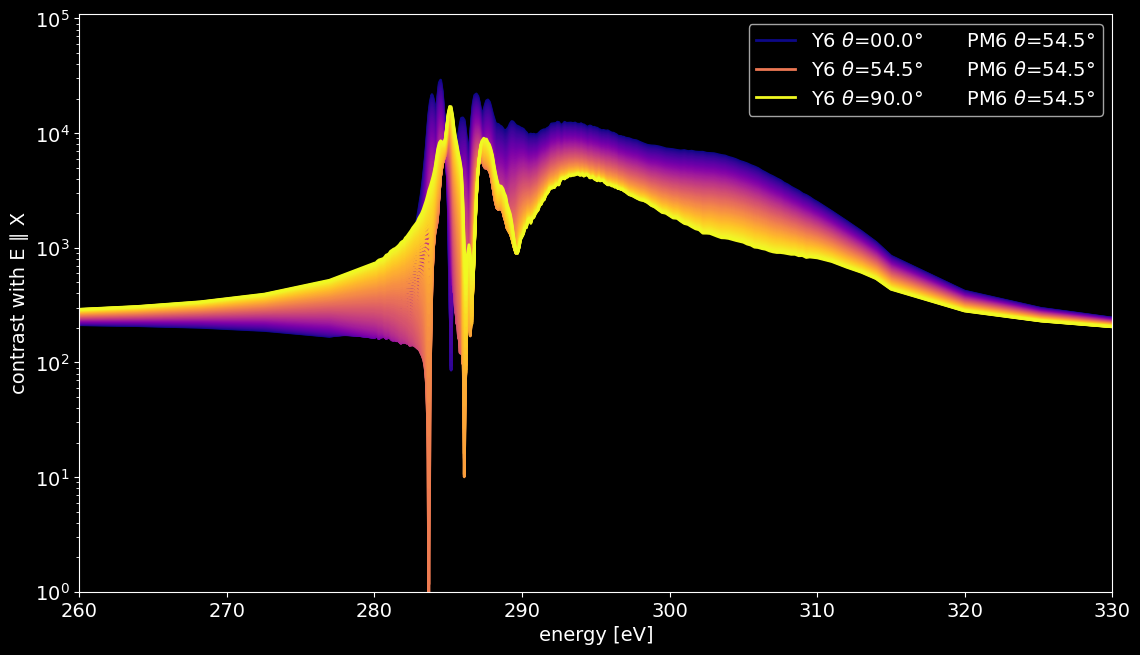

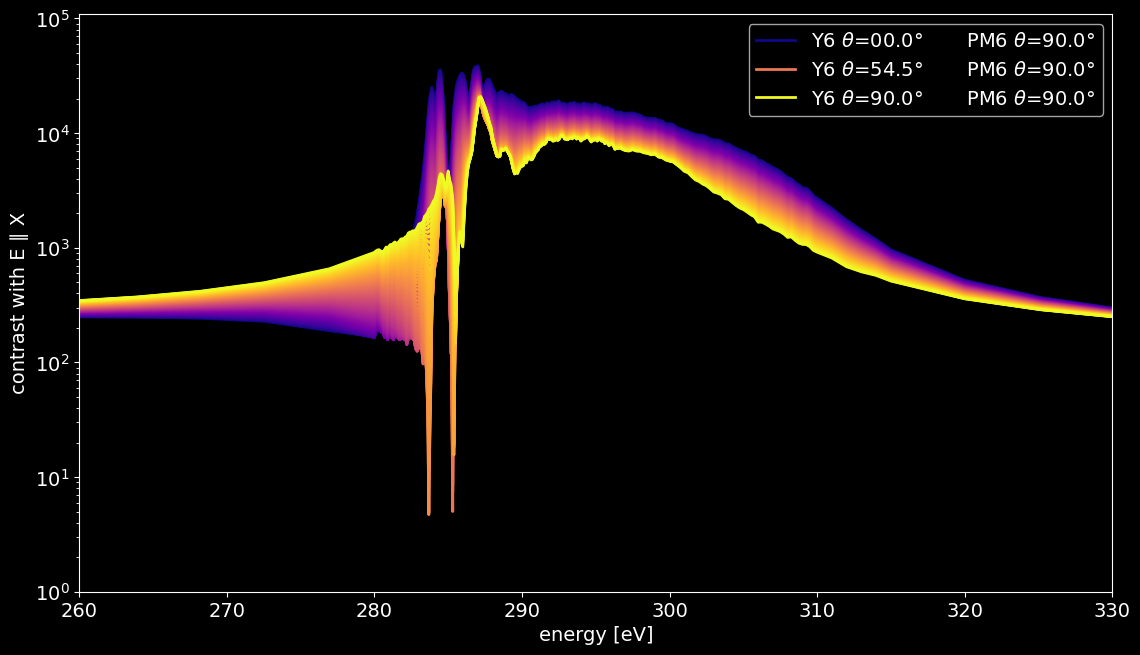

In [62]:
import matplotlib.pyplot as plt
import matplotlib.lines


# build figure here
# subplots(figsize=(h_size, v_size))
xmax = 330

label_thetas = np.array([0, 54.7, 90])
plot_thetas = np.array([0, 54.7, 90])

for i, cos_sq_θ_pm6 in enumerate(n_mol_c.cos_sq_θ_pm6.values):  # n [[89, 0]]:  #
    pm6_theta = np.rad2deg(np.arccos(cos_sq_θ_pm6**0.5))
    do_plot = np.abs(plot_thetas - pm6_theta) < 0.2

    if any(do_plot):
        fig, ax1 = plt.subplots(figsize=(13 + 1 / 3, 7.5))
        for j, cos_sq_θ_y6 in enumerate(n_mol_c.cos_sq_θ_y6.values):
            fracval = j / (n_mol_c.cos_sq_θ_pm6.values.shape[0] - 1)
            y6_theta = np.rad2deg(np.arccos(cos_sq_θ_y6**0.5))
            do_label = np.abs(label_thetas - y6_theta) < 0.2
            if any(do_label):
                trace_label = f"Y6 $\\theta$={y6_theta:04.1f}°"
                trace_label += f"\tPM6 $\\theta$={pm6_theta:04.1f}°"
            else:
                trace_label = ""

            line = (
                n_mol_c.interp(cos_sq_θ_y6=cos_sq_θ_y6)
                .interp(cos_sq_θ_pm6=cos_sq_θ_pm6)
                .plot(
                    ax=ax1,
                    color=colormaps["plasma"](fracval),
                    lw=2,
                    label=trace_label,
                    zorder=0,
                    alpha=1,
                )
            )
            a.append(line)
        ax1.set_xlim(xmin, xmax)
        ymin = contrast_n_mol_y6_vac.sel(energy=slice(xmin, xmax)).min()
        ymax = contrast_n_mol_y6_vac.sel(energy=slice(xmin, xmax)).max()
        ax1.set_ylim(1, ymax * 1.2)
        ax1.set_yscale("log")
        ax1.set_ylabel("contrast with E ∥ X")
        plt.legend()

        plt.title("")
        plt.show()
        plt.close()

The combinatorial contrast is a function of both Y6 orientation and PM6 orientation.

### An interactive widget to explore (oriented Y6):(oriented PM6) contrast

In [63]:
from ipywidgets import interact, widgets, Layout
from IPython.display import clear_output

def f(y6_diel):
    y6_diel = np.cos(np.deg2rad(y6_diel))**2
    fig, ax1 = plt.subplots(figsize=(h_size, v_size))
    label_thetas = np.array([0, 54.7, 90])
    # xarray way of adding to a plot
    colors = plt.cm.plasma(np.linspace(0, 1, n_mol_c.cos_sq_θ_pm6.size))
    for j, cos_sq_θ_pm6 in enumerate(n_mol_c.cos_sq_θ_pm6.values):
        y6_theta = np.rad2deg(np.arccos(y6_diel**0.5))
        pm6_theta = np.rad2deg(np.arccos(cos_sq_θ_pm6**0.5))
        do_label = np.abs(label_thetas - pm6_theta) < 0.2
        if any(do_label):
            trace_label = f"Y6 $\\theta$={y6_theta:04.1f}°"
            trace_label += f"\tPM6 $\\theta$={pm6_theta:04.1f}°"
        else:
            trace_label = ""
        n_mol_c.sel(cos_sq_θ_y6=y6_diel, method = 'nearest').sel(
            cos_sq_θ_pm6=cos_sq_θ_pm6, method="nearest"
        ).plot(ax = ax1, color=colors[j], lw=3, label=trace_label)
    ax1.set_xlim(xmin, xmax)
    ymin = n_mol_c.sel(energy=slice(xmin, xmax)).min()
    ymax = n_mol_c.sel(energy=slice(xmin, xmax)).max()
    ax1.set_ylim(10, ymax * 1.2)
    ax1.set_yscale("log")
    ax1.set_ylabel("contrast")
    plt.title("Y6 contrast with PM6")
    plt.legend()
    # fig.canvas.draw()

interact(
    f,
    y6_diel=widgets.FloatSlider(
    value=54.7,
    min=0,
    max=90.0,
    step=0.1,
    description=f'Y6 θ',
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=Layout(width=str(h_size*0.8)+'in')
),
)

interactive(children=(FloatSlider(value=54.7, description='Y6 θ', layout=Layout(width='8.0in'), max=90.0, read…

<function __main__.f(y6_diel)>

What does this mean?

The representations above define the binary scattering contrasts that are <em>possible</em> in this PM6:Y6 blend, if we don't consider vacuum scattering. It's even broader if we do consider vacuum scattering! Any number of these traces, in any weighted combination, could contribute to the total scattering intensity (TSI) or "scattering invariant" that you measure in a PM6:Y6 system experimentally. 

A key takeaway is that it is essentially impossible to choose an energy at which the TSI will be dominated by <em>composition</em> with no orientation effects. This conclusion tends to be ignored in the analysis that is routinely done in OPV systems as measure of "relative phase purity." Going forward, it is important for the community to understand that orientation effects are likely present in these measurements, and there very likely scenarios where they <em>dominate</em> the response. Rather than being a "bad thing" for the technique, this conclusion emphasizes its unique sensitivity to molecular orientation. 

Frameworks to disentangle orientation effects from composition effects are under development. One demonstrated approach is to model data using the NIST RSoXS Simulation Suite, of which this tutorial is a part.

...creating models that have both composition and orientation fluctuations and fitting those models to RSoXS data at several energies.
